# Learning a Grid Cell Sheet from Place Cells

In this notebook, we will extend the work in our previous model to allow the mappings from place cells to grid cells to be learned dynamically.  To do this, we will need to roughly adopt a two-stage learning method.  In the first stage, grid cells learn to respond to place cells in a familiar environment, creating roughly grid-like firing fields based only on local inhibitory structures.  In the second stage, grid cells begin to learn to conduct path integration.  While this process is ongoing, the grid firing pattern of the grid cells, previously approximate, will regularize as the spatial structure of the local environment is reinforced.

We will begin by implementing this method in a grid cell network covering only one-dimensional space.  We will, similarly, assume that the grid cells are themselves laid out in only one dimension on the cortical sheet.  Later, this method will be extended into two dimensions, although based on the experiences of Widloski & Fiete (2014) we should not expect this transition to be difficult.

As in our previous work, we assume that excitatory grid cells are evenly distributed with fixed direction preferences.  This constraint may be relaxed in later work, but for now is convenient.

In [133]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

from htmresearch.frameworks.grid_cell_learning.DynamicCAN import Dynamic1DCAN
from htmresearch.frameworks.cans.utils import *
import numpy as np
import copy
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [205]:
network = Dynamic1DCAN(numExcitatory=1000,
                       numInhibitory=1000,
                       numPlaces=100,
                       learningRate=.002,
                       dt=0.01, # Time step for numerical integration
                       decayConstant=.03, # Decay rate of neuronal activation, default 0.03
                       stdpWindow=10, # How long a time window in time steps to use for STDP updates.
                       hardwireI=True, # Fix the inhibitory weights
                       boostDecay=60.,
                       boostEffect=15.,
                       learnFactorP=1,
                       tonicMagnitude=5,
                       boostGradient=25,
                       envelopeWidth=0.6,
                       envelopeFactor=50,
                       IEWeightFactor=0.5,
                       gradientType="Linear",
                       roomSize=1,
                       )

<IPython.core.display.Javascript object>


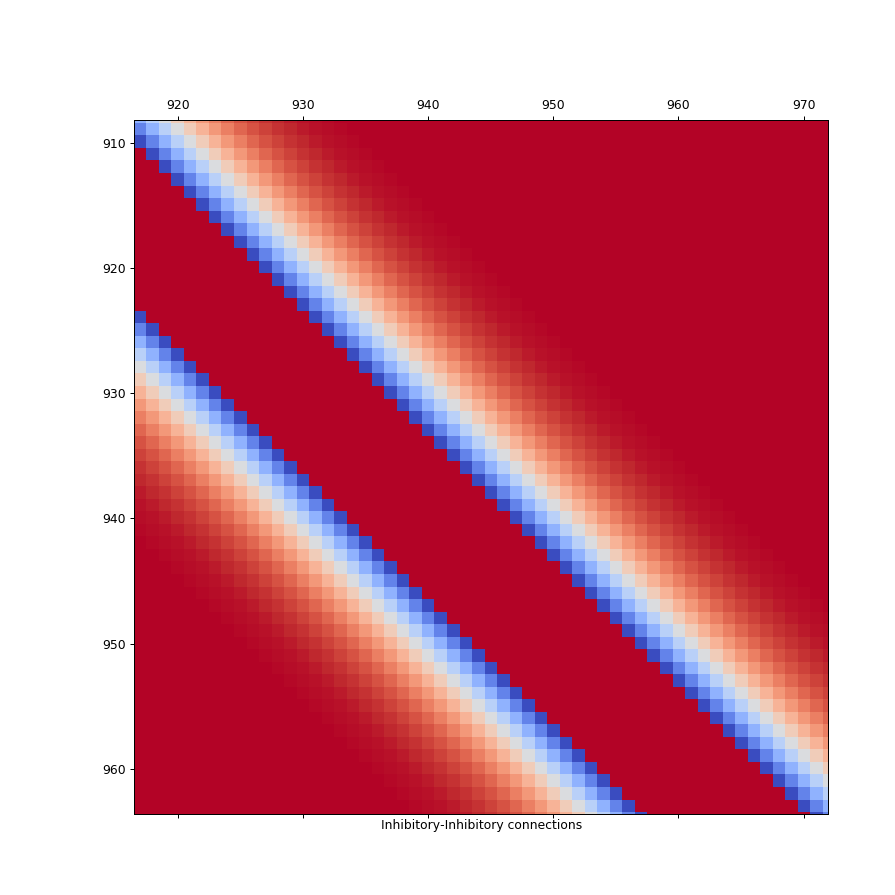

In [200]:
# Nothing much here, before learning
# After learning, should have clear strips across the material
plt.matshow(network.weightsII, cmap=plt.cm.coolwarm)
plt.xlabel("Inhibitory-Inhibitory connections")
plt.show()

<IPython.core.display.Javascript object>


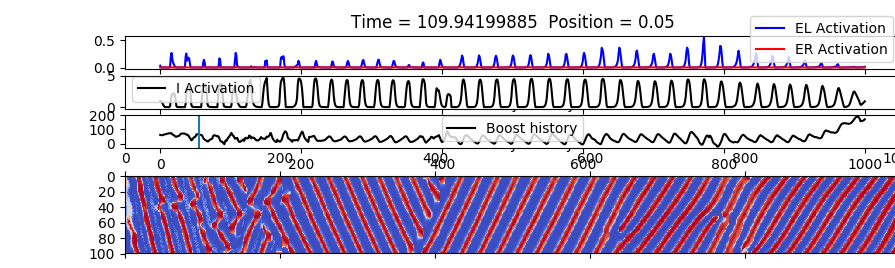

In [ ]:
# Do a set of two passes, starting from the left first and then from the right.
# We have to do one from each direction to learn the asymmetric weights.
network.plotting = True
for i in range(3):
    network.learn(20, # passes in each direction
                       dir=1, # start going left-to-right first
                       periodic=True, # toroidal environment
                       randomSpeed=True,
                       envelope=True,
                       #learnRecurrent=True,
                          )
    print("20 Done")
    network.learn(20, # passes in each direction
                   dir=-1, # start going left-to-right first
                   periodic=True, # toroidal environment
                   randomSpeed=True,
                   envelope=True,
                   #learnRecurrent=True,
                  )
    
    print("20 Done")

In [173]:
np.mean(np.abs(vels))

0.89146238937171463

In [31]:
network.activationsP.shape

(400,)

In [157]:
network.weightsPER = np.copy(network.weightsPI)*3.
network.weightsPEL = np.copy(network.weightsPI)*3.

<IPython.core.display.Javascript object>


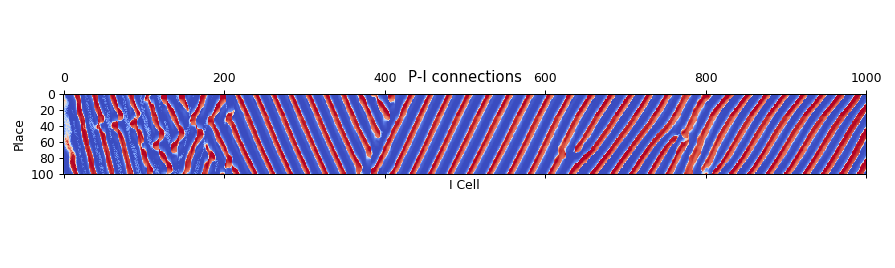

In [209]:
plt.rcParams["figure.figsize"] = [10, 3]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.matshow(network.weightsPI, cmap=plt.cm.coolwarm)
ax1.set_title("P-I connections")
ax1.set_ylabel("Place")
ax1.set_xlabel("I Cell")
plt.tight_layout()
plt.show()

In [160]:
network.plotting=False
network.dt = 0.01
network.alpha = 0.01
network.learningRate = 0.00001
network.boostEffect = 0
network.learn(20, # passes in each direction
              dir=1, # start going left-to-right first
              periodic=True, # toroidal environment
              recurrent=True, # Have the recurrent connections on during training.  Slightly hurts performance.
              randomSpeed=False, # Sets each have a random speed between 0.5 and 1.5x normal
                                 # This should ordinarily be disabled; it is possible to learn the correct connections
                                 # with it active, but it requires many more passes and gradual learning rate decay.
              learnRecurrent=True,
              envelope=True
             )

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


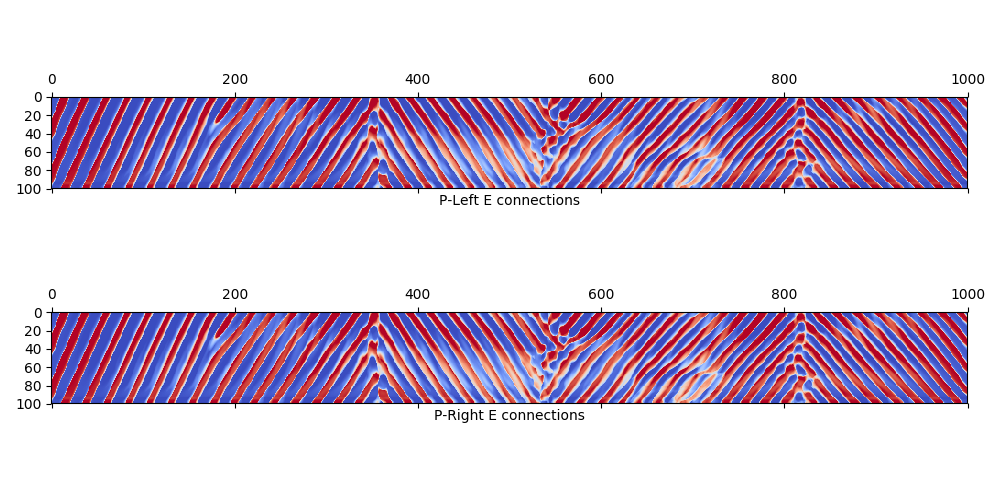

In [134]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.matshow(network.weightsPEL, cmap=plt.cm.coolwarm)
ax1.set_xlabel("P-Left E connections")
ax2.matshow(network.weightsPER, cmap=plt.cm.coolwarm)
ax2.set_xlabel("P-Right E connections")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


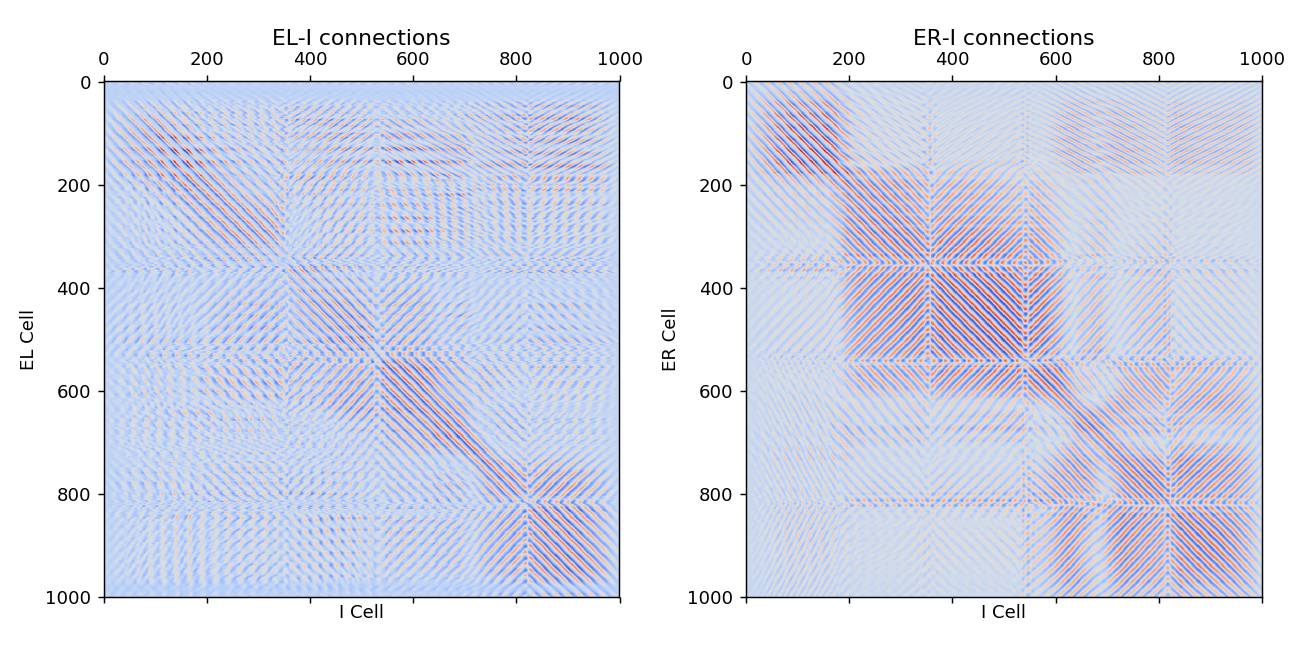

In [161]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.matshow(network.weightsELI, cmap=plt.cm.coolwarm)
ax1.set_title("EL-I connections")
ax1.set_ylabel("EL Cell")
ax1.set_xlabel("I Cell")
ax2.matshow(network.weightsERI, cmap=plt.cm.coolwarm)
ax2.set_title("ER-I connections")
ax2.set_ylabel("ER Cell")
ax2.set_xlabel("I Cell")
plt.tight_layout()
plt.show()

In [196]:
feedforwardInputI=np.ones((1000,))
feedforwardInputE=np.ones((1000,))
sampleFreq=1

# feedforwardInputI[50] += 10
# feedforwardInputE[50] += 10

network.boostDecay=10.
network.plotting = False
results = network.simulate(time=1000, 
                         feedforwardInputI=feedforwardInputI, # The global input to give all inhibitory cells.  Constant.
                         feedforwardInputE=feedforwardInputE, # Also constant for excitatory cells.
                         v=0.0, # Standing still
                         dt=0.01, # Use a smaller time step for simulation, for stability
                         recurrent=True, # Recurrent connections should now be active
                         inputNoise=None, # Noise can be added to the input without compromising results.
                                          # Try using a noise value of 2.
                         envelope=True,
                         sampleFreq=sampleFreq,
                         startFrom=0,
                         )

At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.57
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.69
At 0.7
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.82
At 0.83
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.94
At 0.95
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 1.08
At 1.09
At 1.1
At 1.11
At 1.12
At 1.13
At 1.14
At 1.15
At 1.16
At 1.17
At 1.18
At 1.19
At 1.2
At 1.21
At 1.22
At 1.23
At 1.24
At 1.25
At 1.

At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.45
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.54
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.62
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.7
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.79
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.87
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.95
At 10.96
At 10.97
At 10.98
At 10.99
At 11.0
At 11.01
At 11.02
At 11.03
At 11.04
At 11.05
At 11.06
At 11.07
At 11.08
At 11.09
At 11.1
At 11.11
At 11.12
At 11.13
At 11.14
At 11.15
At 11.16
At 11.17
At 11.18
At 11.19
At 11.2
At 11.21
At 11.22
At 11.23
At 11.24
At 11.25
At 11.26
At 11.27
At 11.28
At 11.29
At 11.3
At 11.31
At 11.32
At 11.33
At 11.34
At 11.35
At 11.36
At 11.37
At 11.38
At 11.39
At 11.4
At 11.41
At 11.42
At 11.43
At 11.44
At 11.45
At 11.46
At 11.47
At 11.48
At 11.49
At 11.5
At 11.51
At 1

At 19.76
At 19.77
At 19.78
At 19.79
At 19.8
At 19.81
At 19.82
At 19.83
At 19.84
At 19.85
At 19.86
At 19.87
At 19.88
At 19.89
At 19.9
At 19.91
At 19.92
At 19.93
At 19.94
At 19.95
At 19.96
At 19.97
At 19.98
At 19.99
At 20.0
At 20.01
At 20.02
At 20.03
At 20.04
At 20.05
At 20.06
At 20.07
At 20.08
At 20.09
At 20.1
At 20.11
At 20.12
At 20.13
At 20.14
At 20.15
At 20.16
At 20.17
At 20.18
At 20.19
At 20.2
At 20.21
At 20.22
At 20.23
At 20.24
At 20.25
At 20.26
At 20.27
At 20.28
At 20.29
At 20.3
At 20.31
At 20.32
At 20.33
At 20.34
At 20.35
At 20.36
At 20.37
At 20.38
At 20.39
At 20.4
At 20.41
At 20.42
At 20.43
At 20.44
At 20.45
At 20.46
At 20.47
At 20.48
At 20.49
At 20.5
At 20.51
At 20.52
At 20.53
At 20.54
At 20.55
At 20.56
At 20.57
At 20.58
At 20.59
At 20.6
At 20.61
At 20.62
At 20.63
At 20.64
At 20.65
At 20.66
At 20.67
At 20.68
At 20.69
At 20.7
At 20.71
At 20.72
At 20.73
At 20.74
At 20.75
At 20.76
At 20.77
At 20.78
At 20.79
At 20.8
At 20.81
At 20.82
At 20.83
At 20.84
At 20.85
At 20.86
At 20.87
At 

At 29.1
At 29.11
At 29.12
At 29.13
At 29.14
At 29.15
At 29.16
At 29.17
At 29.18
At 29.19
At 29.2
At 29.21
At 29.22
At 29.23
At 29.24
At 29.25
At 29.26
At 29.27
At 29.28
At 29.29
At 29.3
At 29.31
At 29.32
At 29.33
At 29.34
At 29.35
At 29.36
At 29.37
At 29.38
At 29.39
At 29.4
At 29.41
At 29.42
At 29.43
At 29.44
At 29.45
At 29.46
At 29.47
At 29.48
At 29.49
At 29.5
At 29.51
At 29.52
At 29.53
At 29.54
At 29.55
At 29.56
At 29.57
At 29.58
At 29.59
At 29.6
At 29.61
At 29.62
At 29.63
At 29.64
At 29.65
At 29.66
At 29.67
At 29.68
At 29.69
At 29.7
At 29.71
At 29.72
At 29.73
At 29.74
At 29.75
At 29.76
At 29.77
At 29.78
At 29.79
At 29.8
At 29.81
At 29.82
At 29.83
At 29.84
At 29.85
At 29.86
At 29.87
At 29.88
At 29.89
At 29.9
At 29.91
At 29.92
At 29.93
At 29.94
At 29.95
At 29.96
At 29.97
At 29.98
At 29.99
At 30.0
At 30.01
At 30.02
At 30.03
At 30.04
At 30.05
At 30.06
At 30.07
At 30.08
At 30.09
At 30.1
At 30.11
At 30.12
At 30.13
At 30.14
At 30.15
At 30.16
At 30.17
At 30.18
At 30.19
At 30.2
At 30.21
At 3

At 38.35
At 38.36
At 38.37
At 38.38
At 38.39
At 38.4
At 38.41
At 38.42
At 38.43
At 38.44
At 38.45
At 38.46
At 38.47
At 38.48
At 38.49
At 38.5
At 38.51
At 38.52
At 38.53
At 38.54
At 38.55
At 38.56
At 38.57
At 38.58
At 38.59
At 38.6
At 38.61
At 38.62
At 38.63
At 38.64
At 38.65
At 38.66
At 38.67
At 38.68
At 38.69
At 38.7
At 38.71
At 38.72
At 38.73
At 38.74
At 38.75
At 38.76
At 38.77
At 38.78
At 38.79
At 38.8
At 38.81
At 38.82
At 38.83
At 38.84
At 38.85
At 38.86
At 38.87
At 38.88
At 38.89
At 38.9
At 38.91
At 38.92
At 38.93
At 38.94
At 38.95
At 38.96
At 38.97
At 38.98
At 38.99
At 39.0
At 39.01
At 39.02
At 39.03
At 39.04
At 39.05
At 39.06
At 39.07
At 39.08
At 39.09
At 39.1
At 39.11
At 39.12
At 39.13
At 39.14
At 39.15
At 39.16
At 39.17
At 39.18
At 39.19
At 39.2
At 39.21
At 39.22
At 39.23
At 39.24
At 39.25
At 39.26
At 39.27
At 39.28
At 39.29
At 39.3
At 39.31
At 39.32
At 39.33
At 39.34
At 39.35
At 39.36
At 39.37
At 39.38
At 39.39
At 39.4
At 39.41
At 39.42
At 39.43
At 39.44
At 39.45
At 39.46
At 

At 47.71
At 47.72
At 47.73
At 47.74
At 47.75
At 47.76
At 47.77
At 47.78
At 47.79
At 47.8
At 47.81
At 47.82
At 47.83
At 47.84
At 47.85
At 47.86
At 47.87
At 47.88
At 47.89
At 47.9
At 47.91
At 47.92
At 47.93
At 47.94
At 47.95
At 47.96
At 47.97
At 47.98
At 47.99
At 48.0
At 48.01
At 48.02
At 48.03
At 48.04
At 48.05
At 48.06
At 48.07
At 48.08
At 48.09
At 48.1
At 48.11
At 48.12
At 48.13
At 48.14
At 48.15
At 48.16
At 48.17
At 48.18
At 48.19
At 48.2
At 48.21
At 48.22
At 48.23
At 48.24
At 48.25
At 48.26
At 48.27
At 48.28
At 48.29
At 48.3
At 48.31
At 48.32
At 48.33
At 48.34
At 48.35
At 48.36
At 48.37
At 48.38
At 48.39
At 48.4
At 48.41
At 48.42
At 48.43
At 48.44
At 48.45
At 48.46
At 48.47
At 48.48
At 48.49
At 48.5
At 48.51
At 48.52
At 48.53
At 48.54
At 48.55
At 48.56
At 48.57
At 48.58
At 48.59
At 48.6
At 48.61
At 48.62
At 48.63
At 48.64
At 48.65
At 48.66
At 48.67
At 48.68
At 48.69
At 48.7
At 48.71
At 48.72
At 48.73
At 48.74
At 48.75
At 48.76
At 48.77
At 48.78
At 48.79
At 48.8
At 48.81
At 48.82
At 

At 56.95
At 56.96
At 56.97
At 56.98
At 56.99
At 57.0
At 57.01
At 57.02
At 57.03
At 57.04
At 57.05
At 57.06
At 57.07
At 57.08
At 57.09
At 57.1
At 57.11
At 57.12
At 57.13
At 57.14
At 57.15
At 57.16
At 57.17
At 57.18
At 57.19
At 57.2
At 57.21
At 57.22
At 57.23
At 57.24
At 57.25
At 57.26
At 57.27
At 57.28
At 57.29
At 57.3
At 57.31
At 57.32
At 57.33
At 57.34
At 57.35
At 57.36
At 57.37
At 57.38
At 57.39
At 57.4
At 57.41
At 57.42
At 57.43
At 57.44
At 57.45
At 57.46
At 57.47
At 57.48
At 57.49
At 57.5
At 57.51
At 57.52
At 57.53
At 57.54
At 57.55
At 57.56
At 57.57
At 57.58
At 57.59
At 57.6
At 57.61
At 57.62
At 57.63
At 57.64
At 57.65
At 57.66
At 57.67
At 57.68
At 57.69
At 57.7
At 57.71
At 57.72
At 57.73
At 57.74
At 57.75
At 57.76
At 57.77
At 57.78
At 57.79
At 57.8
At 57.81
At 57.82
At 57.83
At 57.84
At 57.85
At 57.86
At 57.87
At 57.88
At 57.89
At 57.9
At 57.91
At 57.92
At 57.93
At 57.94
At 57.95
At 57.96
At 57.97
At 57.98
At 57.99
At 58.0
At 58.01
At 58.02
At 58.03
At 58.04
At 58.05
At 58.06
At 

At 66.19
At 66.2
At 66.21
At 66.22
At 66.23
At 66.24
At 66.25
At 66.26
At 66.27
At 66.28
At 66.29
At 66.3
At 66.31
At 66.32
At 66.33
At 66.34
At 66.35
At 66.36
At 66.37
At 66.38
At 66.39
At 66.4
At 66.41
At 66.42
At 66.43
At 66.44
At 66.45
At 66.46
At 66.47
At 66.48
At 66.49
At 66.5
At 66.51
At 66.52
At 66.53
At 66.54
At 66.55
At 66.56
At 66.57
At 66.58
At 66.59
At 66.6
At 66.61
At 66.62
At 66.63
At 66.64
At 66.65
At 66.66
At 66.67
At 66.68
At 66.69
At 66.7
At 66.71
At 66.72
At 66.73
At 66.74
At 66.75
At 66.76
At 66.77
At 66.78
At 66.79
At 66.8
At 66.81
At 66.82
At 66.83
At 66.84
At 66.85
At 66.86
At 66.87
At 66.88
At 66.89
At 66.9
At 66.91
At 66.92
At 66.93
At 66.94
At 66.95
At 66.96
At 66.97
At 66.98
At 66.99
At 67.0
At 67.01
At 67.02
At 67.03
At 67.04
At 67.05
At 67.06
At 67.07
At 67.08
At 67.09
At 67.1
At 67.11
At 67.12
At 67.13
At 67.14
At 67.15
At 67.16
At 67.17
At 67.18
At 67.19
At 67.2
At 67.21
At 67.22
At 67.23
At 67.24
At 67.25
At 67.26
At 67.27
At 67.28
At 67.29
At 67.3
At 6

At 75.46
At 75.47
At 75.48
At 75.49
At 75.5
At 75.51
At 75.52
At 75.53
At 75.54
At 75.55
At 75.56
At 75.57
At 75.58
At 75.59
At 75.6
At 75.61
At 75.62
At 75.63
At 75.64
At 75.65
At 75.66
At 75.67
At 75.68
At 75.69
At 75.7
At 75.71
At 75.72
At 75.73
At 75.74
At 75.75
At 75.76
At 75.77
At 75.78
At 75.79
At 75.8
At 75.81
At 75.82
At 75.83
At 75.84
At 75.85
At 75.86
At 75.87
At 75.88
At 75.89
At 75.9
At 75.91
At 75.92
At 75.93
At 75.94
At 75.95
At 75.96
At 75.97
At 75.98
At 75.99
At 76.0
At 76.01
At 76.02
At 76.03
At 76.04
At 76.05
At 76.06
At 76.07
At 76.08
At 76.09
At 76.1
At 76.11
At 76.12
At 76.13
At 76.14
At 76.15
At 76.16
At 76.17
At 76.18
At 76.19
At 76.2
At 76.21
At 76.22
At 76.23
At 76.24
At 76.25
At 76.26
At 76.27
At 76.28
At 76.29
At 76.3
At 76.31
At 76.32
At 76.33
At 76.34
At 76.35
At 76.36
At 76.37
At 76.38
At 76.39
At 76.4
At 76.41
At 76.42
At 76.43
At 76.44
At 76.45
At 76.46
At 76.47
At 76.48
At 76.49
At 76.5
At 76.51
At 76.52
At 76.53
At 76.54
At 76.55
At 76.56
At 76.57
At 

At 84.74
At 84.75
At 84.76
At 84.77
At 84.78
At 84.79
At 84.8
At 84.81
At 84.82
At 84.83
At 84.84
At 84.85
At 84.86
At 84.87
At 84.88
At 84.89
At 84.9
At 84.91
At 84.92
At 84.93
At 84.94
At 84.95
At 84.96
At 84.97
At 84.98
At 84.99
At 85.0
At 85.01
At 85.02
At 85.03
At 85.04
At 85.05
At 85.06
At 85.07
At 85.08
At 85.09
At 85.1
At 85.11
At 85.12
At 85.13
At 85.14
At 85.15
At 85.16
At 85.17
At 85.18
At 85.19
At 85.2
At 85.21
At 85.22
At 85.23
At 85.24
At 85.25
At 85.26
At 85.27
At 85.28
At 85.29
At 85.3
At 85.31
At 85.32
At 85.33
At 85.34
At 85.35
At 85.36
At 85.37
At 85.38
At 85.39
At 85.4
At 85.41
At 85.42
At 85.43
At 85.44
At 85.45
At 85.46
At 85.47
At 85.48
At 85.49
At 85.5
At 85.51
At 85.52
At 85.53
At 85.54
At 85.55
At 85.56
At 85.57
At 85.58
At 85.59
At 85.6
At 85.61
At 85.62
At 85.63
At 85.64
At 85.65
At 85.66
At 85.67
At 85.68
At 85.69
At 85.7
At 85.71
At 85.72
At 85.73
At 85.74
At 85.75
At 85.76
At 85.77
At 85.78
At 85.79
At 85.8
At 85.81
At 85.82
At 85.83
At 85.84
At 85.85
At 

At 94.04
At 94.05
At 94.06
At 94.07
At 94.08
At 94.09
At 94.1
At 94.11
At 94.12
At 94.13
At 94.14
At 94.15
At 94.16
At 94.17
At 94.18
At 94.19
At 94.2
At 94.21
At 94.22
At 94.23
At 94.24
At 94.25
At 94.26
At 94.27
At 94.28
At 94.29
At 94.3
At 94.31
At 94.32
At 94.33
At 94.34
At 94.35
At 94.36
At 94.37
At 94.38
At 94.39
At 94.4
At 94.41
At 94.42
At 94.43
At 94.44
At 94.45
At 94.46
At 94.47
At 94.48
At 94.49
At 94.5
At 94.51
At 94.52
At 94.53
At 94.54
At 94.55
At 94.56
At 94.57
At 94.58
At 94.59
At 94.6
At 94.61
At 94.62
At 94.63
At 94.64
At 94.65
At 94.66
At 94.67
At 94.68
At 94.69
At 94.7
At 94.71
At 94.72
At 94.73
At 94.74
At 94.75
At 94.76
At 94.77
At 94.78
At 94.79
At 94.8
At 94.81
At 94.82
At 94.83
At 94.84
At 94.85
At 94.86
At 94.87
At 94.88
At 94.89
At 94.9
At 94.91
At 94.92
At 94.93
At 94.94
At 94.95
At 94.96
At 94.97
At 94.98
At 94.99
At 95.0
At 95.01
At 95.02
At 95.03
At 95.04
At 95.05
At 95.06
At 95.07
At 95.08
At 95.09
At 95.1
At 95.11
At 95.12
At 95.13
At 95.14
At 95.15
At 

At 102.99
At 103.0
At 103.01
At 103.02
At 103.03
At 103.04
At 103.05
At 103.06
At 103.07
At 103.08
At 103.09
At 103.1
At 103.11
At 103.12
At 103.13
At 103.14
At 103.15
At 103.16
At 103.17
At 103.18
At 103.19
At 103.2
At 103.21
At 103.22
At 103.23
At 103.24
At 103.25
At 103.26
At 103.27
At 103.28
At 103.29
At 103.3
At 103.31
At 103.32
At 103.33
At 103.34
At 103.35
At 103.36
At 103.37
At 103.38
At 103.39
At 103.4
At 103.41
At 103.42
At 103.43
At 103.44
At 103.45
At 103.46
At 103.47
At 103.48
At 103.49
At 103.5
At 103.51
At 103.52
At 103.53
At 103.54
At 103.55
At 103.56
At 103.57
At 103.58
At 103.59
At 103.6
At 103.61
At 103.62
At 103.63
At 103.64
At 103.65
At 103.66
At 103.67
At 103.68
At 103.69
At 103.7
At 103.71
At 103.72
At 103.73
At 103.74
At 103.75
At 103.76
At 103.77
At 103.78
At 103.79
At 103.8
At 103.81
At 103.82
At 103.83
At 103.84
At 103.85
At 103.86
At 103.87
At 103.88
At 103.89
At 103.9
At 103.91
At 103.92
At 103.93
At 103.94
At 103.95
At 103.96
At 103.97
At 103.98
At 103.99


At 111.29
At 111.3
At 111.31
At 111.32
At 111.33
At 111.34
At 111.35
At 111.36
At 111.37
At 111.38
At 111.39
At 111.4
At 111.41
At 111.42
At 111.43
At 111.44
At 111.45
At 111.46
At 111.47
At 111.48
At 111.49
At 111.5
At 111.51
At 111.52
At 111.53
At 111.54
At 111.55
At 111.56
At 111.57
At 111.58
At 111.59
At 111.6
At 111.61
At 111.62
At 111.63
At 111.64
At 111.65
At 111.66
At 111.67
At 111.68
At 111.69
At 111.7
At 111.71
At 111.72
At 111.73
At 111.74
At 111.75
At 111.76
At 111.77
At 111.78
At 111.79
At 111.8
At 111.81
At 111.82
At 111.83
At 111.84
At 111.85
At 111.86
At 111.87
At 111.88
At 111.89
At 111.9
At 111.91
At 111.92
At 111.93
At 111.94
At 111.95
At 111.96
At 111.97
At 111.98
At 111.99
At 112.0
At 112.01
At 112.02
At 112.03
At 112.04
At 112.05
At 112.06
At 112.07
At 112.08
At 112.09
At 112.1
At 112.11
At 112.12
At 112.13
At 112.14
At 112.15
At 112.16
At 112.17
At 112.18
At 112.19
At 112.2
At 112.21
At 112.22
At 112.23
At 112.24
At 112.25
At 112.26
At 112.27
At 112.28
At 112.29


At 119.59
At 119.6
At 119.61
At 119.62
At 119.63
At 119.64
At 119.65
At 119.66
At 119.67
At 119.68
At 119.69
At 119.7
At 119.71
At 119.72
At 119.73
At 119.74
At 119.75
At 119.76
At 119.77
At 119.78
At 119.79
At 119.8
At 119.81
At 119.82
At 119.83
At 119.84
At 119.85
At 119.86
At 119.87
At 119.88
At 119.89
At 119.9
At 119.91
At 119.92
At 119.93
At 119.94
At 119.95
At 119.96
At 119.97
At 119.98
At 119.99
At 120.0
At 120.01
At 120.02
At 120.03
At 120.04
At 120.05
At 120.06
At 120.07
At 120.08
At 120.09
At 120.1
At 120.11
At 120.12
At 120.13
At 120.14
At 120.15
At 120.16
At 120.17
At 120.18
At 120.19
At 120.2
At 120.21
At 120.22
At 120.23
At 120.24
At 120.25
At 120.26
At 120.27
At 120.28
At 120.29
At 120.3
At 120.31
At 120.32
At 120.33
At 120.34
At 120.35
At 120.36
At 120.37
At 120.38
At 120.39
At 120.4
At 120.41
At 120.42
At 120.43
At 120.44
At 120.45
At 120.46
At 120.47
At 120.48
At 120.49
At 120.5
At 120.51
At 120.52
At 120.53
At 120.54
At 120.55
At 120.56
At 120.57
At 120.58
At 120.59


At 127.91
At 127.92
At 127.93
At 127.94
At 127.95
At 127.96
At 127.97
At 127.98
At 127.99
At 128.0
At 128.01
At 128.02
At 128.03
At 128.04
At 128.05
At 128.06
At 128.07
At 128.08
At 128.09
At 128.1
At 128.11
At 128.12
At 128.13
At 128.14
At 128.15
At 128.16
At 128.17
At 128.18
At 128.19
At 128.2
At 128.21
At 128.22
At 128.23
At 128.24
At 128.25
At 128.26
At 128.27
At 128.28
At 128.29
At 128.3
At 128.31
At 128.32
At 128.33
At 128.34
At 128.35
At 128.36
At 128.37
At 128.38
At 128.39
At 128.4
At 128.41
At 128.42
At 128.43
At 128.44
At 128.45
At 128.46
At 128.47
At 128.48
At 128.49
At 128.5
At 128.51
At 128.52
At 128.53
At 128.54
At 128.55
At 128.56
At 128.57
At 128.58
At 128.59
At 128.6
At 128.61
At 128.62
At 128.63
At 128.64
At 128.65
At 128.66
At 128.67
At 128.68
At 128.69
At 128.7
At 128.71
At 128.72
At 128.73
At 128.74
At 128.75
At 128.76
At 128.77
At 128.78
At 128.79
At 128.8
At 128.81
At 128.82
At 128.83
At 128.84
At 128.85
At 128.86
At 128.87
At 128.88
At 128.89
At 128.9
At 128.91


At 136.23
At 136.24
At 136.25
At 136.26
At 136.27
At 136.28
At 136.29
At 136.3
At 136.31
At 136.32
At 136.33
At 136.34
At 136.35
At 136.36
At 136.37
At 136.38
At 136.39
At 136.4
At 136.41
At 136.42
At 136.43
At 136.44
At 136.45
At 136.46
At 136.47
At 136.48
At 136.49
At 136.5
At 136.51
At 136.52
At 136.53
At 136.54
At 136.55
At 136.56
At 136.57
At 136.58
At 136.59
At 136.6
At 136.61
At 136.62
At 136.63
At 136.64
At 136.65
At 136.66
At 136.67
At 136.68
At 136.69
At 136.7
At 136.71
At 136.72
At 136.73
At 136.74
At 136.75
At 136.76
At 136.77
At 136.78
At 136.79
At 136.8
At 136.81
At 136.82
At 136.83
At 136.84
At 136.85
At 136.86
At 136.87
At 136.88
At 136.89
At 136.9
At 136.91
At 136.92
At 136.93
At 136.94
At 136.95
At 136.96
At 136.97
At 136.98
At 136.99
At 137.0
At 137.01
At 137.02
At 137.03
At 137.04
At 137.05
At 137.06
At 137.07
At 137.08
At 137.09
At 137.1
At 137.11
At 137.12
At 137.13
At 137.14
At 137.15
At 137.16
At 137.17
At 137.18
At 137.19
At 137.2
At 137.21
At 137.22
At 137.23


At 144.53
At 144.54
At 144.55
At 144.56
At 144.57
At 144.58
At 144.59
At 144.6
At 144.61
At 144.62
At 144.63
At 144.64
At 144.65
At 144.66
At 144.67
At 144.68
At 144.69
At 144.7
At 144.71
At 144.72
At 144.73
At 144.74
At 144.75
At 144.76
At 144.77
At 144.78
At 144.79
At 144.8
At 144.81
At 144.82
At 144.83
At 144.84
At 144.85
At 144.86
At 144.87
At 144.88
At 144.89
At 144.9
At 144.91
At 144.92
At 144.93
At 144.94
At 144.95
At 144.96
At 144.97
At 144.98
At 144.99
At 145.0
At 145.01
At 145.02
At 145.03
At 145.04
At 145.05
At 145.06
At 145.07
At 145.08
At 145.09
At 145.1
At 145.11
At 145.12
At 145.13
At 145.14
At 145.15
At 145.16
At 145.17
At 145.18
At 145.19
At 145.2
At 145.21
At 145.22
At 145.23
At 145.24
At 145.25
At 145.26
At 145.27
At 145.28
At 145.29
At 145.3
At 145.31
At 145.32
At 145.33
At 145.34
At 145.35
At 145.36
At 145.37
At 145.38
At 145.39
At 145.4
At 145.41
At 145.42
At 145.43
At 145.44
At 145.45
At 145.46
At 145.47
At 145.48
At 145.49
At 145.5
At 145.51
At 145.52
At 145.53


At 152.85
At 152.86
At 152.87
At 152.88
At 152.89
At 152.9
At 152.91
At 152.92
At 152.93
At 152.94
At 152.95
At 152.96
At 152.97
At 152.98
At 152.99
At 153.0
At 153.01
At 153.02
At 153.03
At 153.04
At 153.05
At 153.06
At 153.07
At 153.08
At 153.09
At 153.1
At 153.11
At 153.12
At 153.13
At 153.14
At 153.15
At 153.16
At 153.17
At 153.18
At 153.19
At 153.2
At 153.21
At 153.22
At 153.23
At 153.24
At 153.25
At 153.26
At 153.27
At 153.28
At 153.29
At 153.3
At 153.31
At 153.32
At 153.33
At 153.34
At 153.35
At 153.36
At 153.37
At 153.38
At 153.39
At 153.4
At 153.41
At 153.42
At 153.43
At 153.44
At 153.45
At 153.46
At 153.47
At 153.48
At 153.49
At 153.5
At 153.51
At 153.52
At 153.53
At 153.54
At 153.55
At 153.56
At 153.57
At 153.58
At 153.59
At 153.6
At 153.61
At 153.62
At 153.63
At 153.64
At 153.65
At 153.66
At 153.67
At 153.68
At 153.69
At 153.7
At 153.71
At 153.72
At 153.73
At 153.74
At 153.75
At 153.76
At 153.77
At 153.78
At 153.79
At 153.8
At 153.81
At 153.82
At 153.83
At 153.84
At 153.85


At 161.14
At 161.15
At 161.16
At 161.17
At 161.18
At 161.19
At 161.2
At 161.21
At 161.22
At 161.23
At 161.24
At 161.25
At 161.26
At 161.27
At 161.28
At 161.29
At 161.3
At 161.31
At 161.32
At 161.33
At 161.34
At 161.35
At 161.36
At 161.37
At 161.38
At 161.39
At 161.4
At 161.41
At 161.42
At 161.43
At 161.44
At 161.45
At 161.46
At 161.47
At 161.48
At 161.49
At 161.5
At 161.51
At 161.52
At 161.53
At 161.54
At 161.55
At 161.56
At 161.57
At 161.58
At 161.59
At 161.6
At 161.61
At 161.62
At 161.63
At 161.64
At 161.65
At 161.66
At 161.67
At 161.68
At 161.69
At 161.7
At 161.71
At 161.72
At 161.73
At 161.74
At 161.75
At 161.76
At 161.77
At 161.78
At 161.79
At 161.8
At 161.81
At 161.82
At 161.83
At 161.84
At 161.85
At 161.86
At 161.87
At 161.88
At 161.89
At 161.9
At 161.91
At 161.92
At 161.93
At 161.94
At 161.95
At 161.96
At 161.97
At 161.98
At 161.99
At 162.0
At 162.01
At 162.02
At 162.03
At 162.04
At 162.05
At 162.06
At 162.07
At 162.08
At 162.09
At 162.1
At 162.11
At 162.12
At 162.13
At 162.14


At 169.42
At 169.43
At 169.44
At 169.45
At 169.46
At 169.47
At 169.48
At 169.49
At 169.5
At 169.51
At 169.52
At 169.53
At 169.54
At 169.55
At 169.56
At 169.57
At 169.58
At 169.59
At 169.6
At 169.61
At 169.62
At 169.63
At 169.64
At 169.65
At 169.66
At 169.67
At 169.68
At 169.69
At 169.7
At 169.71
At 169.72
At 169.73
At 169.74
At 169.75
At 169.76
At 169.77
At 169.78
At 169.79
At 169.8
At 169.81
At 169.82
At 169.83
At 169.84
At 169.85
At 169.86
At 169.87
At 169.88
At 169.89
At 169.9
At 169.91
At 169.92
At 169.93
At 169.94
At 169.95
At 169.96
At 169.97
At 169.98
At 169.99
At 170.0
At 170.01
At 170.02
At 170.03
At 170.04
At 170.05
At 170.06
At 170.07
At 170.08
At 170.09
At 170.1
At 170.11
At 170.12
At 170.13
At 170.14
At 170.15
At 170.16
At 170.17
At 170.18
At 170.19
At 170.2
At 170.21
At 170.22
At 170.23
At 170.24
At 170.25
At 170.26
At 170.27
At 170.28
At 170.29
At 170.3
At 170.31
At 170.32
At 170.33
At 170.34
At 170.35
At 170.36
At 170.37
At 170.38
At 170.39
At 170.4
At 170.41
At 170.42


At 177.73
At 177.74
At 177.75
At 177.76
At 177.77
At 177.78
At 177.79
At 177.8
At 177.81
At 177.82
At 177.83
At 177.84
At 177.85
At 177.86
At 177.87
At 177.88
At 177.89
At 177.9
At 177.91
At 177.92
At 177.93
At 177.94
At 177.95
At 177.96
At 177.97
At 177.98
At 177.99
At 178.0
At 178.01
At 178.02
At 178.03
At 178.04
At 178.05
At 178.06
At 178.07
At 178.08
At 178.09
At 178.1
At 178.11
At 178.12
At 178.13
At 178.14
At 178.15
At 178.16
At 178.17
At 178.18
At 178.19
At 178.2
At 178.21
At 178.22
At 178.23
At 178.24
At 178.25
At 178.26
At 178.27
At 178.28
At 178.29
At 178.3
At 178.31
At 178.32
At 178.33
At 178.34
At 178.35
At 178.36
At 178.37
At 178.38
At 178.39
At 178.4
At 178.41
At 178.42
At 178.43
At 178.44
At 178.45
At 178.46
At 178.47
At 178.48
At 178.49
At 178.5
At 178.51
At 178.52
At 178.53
At 178.54
At 178.55
At 178.56
At 178.57
At 178.58
At 178.59
At 178.6
At 178.61
At 178.62
At 178.63
At 178.64
At 178.65
At 178.66
At 178.67
At 178.68
At 178.69
At 178.7
At 178.71
At 178.72
At 178.73


At 186.13
At 186.14
At 186.15
At 186.16
At 186.17
At 186.18
At 186.19
At 186.2
At 186.21
At 186.22
At 186.23
At 186.24
At 186.25
At 186.26
At 186.27
At 186.28
At 186.29
At 186.3
At 186.31
At 186.32
At 186.33
At 186.34
At 186.35
At 186.36
At 186.37
At 186.38
At 186.39
At 186.4
At 186.41
At 186.42
At 186.43
At 186.44
At 186.45
At 186.46
At 186.47
At 186.48
At 186.49
At 186.5
At 186.51
At 186.52
At 186.53
At 186.54
At 186.55
At 186.56
At 186.57
At 186.58
At 186.59
At 186.6
At 186.61
At 186.62
At 186.63
At 186.64
At 186.65
At 186.66
At 186.67
At 186.68
At 186.69
At 186.7
At 186.71
At 186.72
At 186.73
At 186.74
At 186.75
At 186.76
At 186.77
At 186.78
At 186.79
At 186.8
At 186.81
At 186.82
At 186.83
At 186.84
At 186.85
At 186.86
At 186.87
At 186.88
At 186.89
At 186.9
At 186.91
At 186.92
At 186.93
At 186.94
At 186.95
At 186.96
At 186.97
At 186.98
At 186.99
At 187.0
At 187.01
At 187.02
At 187.03
At 187.04
At 187.05
At 187.06
At 187.07
At 187.08
At 187.09
At 187.1
At 187.11
At 187.12
At 187.13


At 194.52
At 194.53
At 194.54
At 194.55
At 194.56
At 194.57
At 194.58
At 194.59
At 194.6
At 194.61
At 194.62
At 194.63
At 194.64
At 194.65
At 194.66
At 194.67
At 194.68
At 194.69
At 194.7
At 194.71
At 194.72
At 194.73
At 194.74
At 194.75
At 194.76
At 194.77
At 194.78
At 194.79
At 194.8
At 194.81
At 194.82
At 194.83
At 194.84
At 194.85
At 194.86
At 194.87
At 194.88
At 194.89
At 194.9
At 194.91
At 194.92
At 194.93
At 194.94
At 194.95
At 194.96
At 194.97
At 194.98
At 194.99
At 195.0
At 195.01
At 195.02
At 195.03
At 195.04
At 195.05
At 195.06
At 195.07
At 195.08
At 195.09
At 195.1
At 195.11
At 195.12
At 195.13
At 195.14
At 195.15
At 195.16
At 195.17
At 195.18
At 195.19
At 195.2
At 195.21
At 195.22
At 195.23
At 195.24
At 195.25
At 195.26
At 195.27
At 195.28
At 195.29
At 195.3
At 195.31
At 195.32
At 195.33
At 195.34
At 195.35
At 195.36
At 195.37
At 195.38
At 195.39
At 195.4
At 195.41
At 195.42
At 195.43
At 195.44
At 195.45
At 195.46
At 195.47
At 195.48
At 195.49
At 195.5
At 195.51
At 195.52


At 202.89
At 202.9
At 202.91
At 202.92
At 202.93
At 202.94
At 202.95
At 202.96
At 202.97
At 202.98
At 202.99
At 203.0
At 203.01
At 203.02
At 203.03
At 203.04
At 203.05
At 203.06
At 203.07
At 203.08
At 203.09
At 203.1
At 203.11
At 203.12
At 203.13
At 203.14
At 203.15
At 203.16
At 203.17
At 203.18
At 203.19
At 203.2
At 203.21
At 203.22
At 203.23
At 203.24
At 203.25
At 203.26
At 203.27
At 203.28
At 203.29
At 203.3
At 203.31
At 203.32
At 203.33
At 203.34
At 203.35
At 203.36
At 203.37
At 203.38
At 203.39
At 203.4
At 203.41
At 203.42
At 203.43
At 203.44
At 203.45
At 203.46
At 203.47
At 203.48
At 203.49
At 203.5
At 203.51
At 203.52
At 203.53
At 203.54
At 203.55
At 203.56
At 203.57
At 203.58
At 203.59
At 203.6
At 203.61
At 203.62
At 203.63
At 203.64
At 203.65
At 203.66
At 203.67
At 203.68
At 203.69
At 203.7
At 203.71
At 203.72
At 203.73
At 203.74
At 203.75
At 203.76
At 203.77
At 203.78
At 203.79
At 203.8
At 203.81
At 203.82
At 203.83
At 203.84
At 203.85
At 203.86
At 203.87
At 203.88
At 203.89


At 211.2
At 211.21
At 211.22
At 211.23
At 211.24
At 211.25
At 211.26
At 211.27
At 211.28
At 211.29
At 211.3
At 211.31
At 211.32
At 211.33
At 211.34
At 211.35
At 211.36
At 211.37
At 211.38
At 211.39
At 211.4
At 211.41
At 211.42
At 211.43
At 211.44
At 211.45
At 211.46
At 211.47
At 211.48
At 211.49
At 211.5
At 211.51
At 211.52
At 211.53
At 211.54
At 211.55
At 211.56
At 211.57
At 211.58
At 211.59
At 211.6
At 211.61
At 211.62
At 211.63
At 211.64
At 211.65
At 211.66
At 211.67
At 211.68
At 211.69
At 211.7
At 211.71
At 211.72
At 211.73
At 211.74
At 211.75
At 211.76
At 211.77
At 211.78
At 211.79
At 211.8
At 211.81
At 211.82
At 211.83
At 211.84
At 211.85
At 211.86
At 211.87
At 211.88
At 211.89
At 211.9
At 211.91
At 211.92
At 211.93
At 211.94
At 211.95
At 211.96
At 211.97
At 211.98
At 211.99
At 212.0
At 212.01
At 212.02
At 212.03
At 212.04
At 212.05
At 212.06
At 212.07
At 212.08
At 212.09
At 212.1
At 212.11
At 212.12
At 212.13
At 212.14
At 212.15
At 212.16
At 212.17
At 212.18
At 212.19
At 212.2
A

At 219.6
At 219.61
At 219.62
At 219.63
At 219.64
At 219.65
At 219.66
At 219.67
At 219.68
At 219.69
At 219.7
At 219.71
At 219.72
At 219.73
At 219.74
At 219.75
At 219.76
At 219.77
At 219.78
At 219.79
At 219.8
At 219.81
At 219.82
At 219.83
At 219.84
At 219.85
At 219.86
At 219.87
At 219.88
At 219.89
At 219.9
At 219.91
At 219.92
At 219.93
At 219.94
At 219.95
At 219.96
At 219.97
At 219.98
At 219.99
At 220.0
At 220.01
At 220.02
At 220.03
At 220.04
At 220.05
At 220.06
At 220.07
At 220.08
At 220.09
At 220.1
At 220.11
At 220.12
At 220.13
At 220.14
At 220.15
At 220.16
At 220.17
At 220.18
At 220.19
At 220.2
At 220.21
At 220.22
At 220.23
At 220.24
At 220.25
At 220.26
At 220.27
At 220.28
At 220.29
At 220.3
At 220.31
At 220.32
At 220.33
At 220.34
At 220.35
At 220.36
At 220.37
At 220.38
At 220.39
At 220.4
At 220.41
At 220.42
At 220.43
At 220.44
At 220.45
At 220.46
At 220.47
At 220.48
At 220.49
At 220.5
At 220.51
At 220.52
At 220.53
At 220.54
At 220.55
At 220.56
At 220.57
At 220.58
At 220.59
At 220.6
A

At 228.0
At 228.01
At 228.02
At 228.03
At 228.04
At 228.05
At 228.06
At 228.07
At 228.08
At 228.09
At 228.1
At 228.11
At 228.12
At 228.13
At 228.14
At 228.15
At 228.16
At 228.17
At 228.18
At 228.19
At 228.2
At 228.21
At 228.22
At 228.23
At 228.24
At 228.25
At 228.26
At 228.27
At 228.28
At 228.29
At 228.3
At 228.31
At 228.32
At 228.33
At 228.34
At 228.35
At 228.36
At 228.37
At 228.38
At 228.39
At 228.4
At 228.41
At 228.42
At 228.43
At 228.44
At 228.45
At 228.46
At 228.47
At 228.48
At 228.49
At 228.5
At 228.51
At 228.52
At 228.53
At 228.54
At 228.55
At 228.56
At 228.57
At 228.58
At 228.59
At 228.6
At 228.61
At 228.62
At 228.63
At 228.64
At 228.65
At 228.66
At 228.67
At 228.68
At 228.69
At 228.7
At 228.71
At 228.72
At 228.73
At 228.74
At 228.75
At 228.76
At 228.77
At 228.78
At 228.79
At 228.8
At 228.81
At 228.82
At 228.83
At 228.84
At 228.85
At 228.86
At 228.87
At 228.88
At 228.89
At 228.9
At 228.91
At 228.92
At 228.93
At 228.94
At 228.95
At 228.96
At 228.97
At 228.98
At 228.99
At 229.0
A

At 236.32
At 236.33
At 236.34
At 236.35
At 236.36
At 236.37
At 236.38
At 236.39
At 236.4
At 236.41
At 236.42
At 236.43
At 236.44
At 236.45
At 236.46
At 236.47
At 236.48
At 236.49
At 236.5
At 236.51
At 236.52
At 236.53
At 236.54
At 236.55
At 236.56
At 236.57
At 236.58
At 236.59
At 236.6
At 236.61
At 236.62
At 236.63
At 236.64
At 236.65
At 236.66
At 236.67
At 236.68
At 236.69
At 236.7
At 236.71
At 236.72
At 236.73
At 236.74
At 236.75
At 236.76
At 236.77
At 236.78
At 236.79
At 236.8
At 236.81
At 236.82
At 236.83
At 236.84
At 236.85
At 236.86
At 236.87
At 236.88
At 236.89
At 236.9
At 236.91
At 236.92
At 236.93
At 236.94
At 236.95
At 236.96
At 236.97
At 236.98
At 236.99
At 237.0
At 237.01
At 237.02
At 237.03
At 237.04
At 237.05
At 237.06
At 237.07
At 237.08
At 237.09
At 237.1
At 237.11
At 237.12
At 237.13
At 237.14
At 237.15
At 237.16
At 237.17
At 237.18
At 237.19
At 237.2
At 237.21
At 237.22
At 237.23
At 237.24
At 237.25
At 237.26
At 237.27
At 237.28
At 237.29
At 237.3
At 237.31
At 237.32


At 244.64
At 244.65
At 244.66
At 244.67
At 244.68
At 244.69
At 244.7
At 244.71
At 244.72
At 244.73
At 244.74
At 244.75
At 244.76
At 244.77
At 244.78
At 244.79
At 244.8
At 244.81
At 244.82
At 244.83
At 244.84
At 244.85
At 244.86
At 244.87
At 244.88
At 244.89
At 244.9
At 244.91
At 244.92
At 244.93
At 244.94
At 244.95
At 244.96
At 244.97
At 244.98
At 244.99
At 245.0
At 245.01
At 245.02
At 245.03
At 245.04
At 245.05
At 245.06
At 245.07
At 245.08
At 245.09
At 245.1
At 245.11
At 245.12
At 245.13
At 245.14
At 245.15
At 245.16
At 245.17
At 245.18
At 245.19
At 245.2
At 245.21
At 245.22
At 245.23
At 245.24
At 245.25
At 245.26
At 245.27
At 245.28
At 245.29
At 245.3
At 245.31
At 245.32
At 245.33
At 245.34
At 245.35
At 245.36
At 245.37
At 245.38
At 245.39
At 245.4
At 245.41
At 245.42
At 245.43
At 245.44
At 245.45
At 245.46
At 245.47
At 245.48
At 245.49
At 245.5
At 245.51
At 245.52
At 245.53
At 245.54
At 245.55
At 245.56
At 245.57
At 245.58
At 245.59
At 245.6
At 245.61
At 245.62
At 245.63
At 245.64


At 252.96
At 252.97
At 252.98
At 252.99
At 253.0
At 253.01
At 253.02
At 253.03
At 253.04
At 253.05
At 253.06
At 253.07
At 253.08
At 253.09
At 253.1
At 253.11
At 253.12
At 253.13
At 253.14
At 253.15
At 253.16
At 253.17
At 253.18
At 253.19
At 253.2
At 253.21
At 253.22
At 253.23
At 253.24
At 253.25
At 253.26
At 253.27
At 253.28
At 253.29
At 253.3
At 253.31
At 253.32
At 253.33
At 253.34
At 253.35
At 253.36
At 253.37
At 253.38
At 253.39
At 253.4
At 253.41
At 253.42
At 253.43
At 253.44
At 253.45
At 253.46
At 253.47
At 253.48
At 253.49
At 253.5
At 253.51
At 253.52
At 253.53
At 253.54
At 253.55
At 253.56
At 253.57
At 253.58
At 253.59
At 253.6
At 253.61
At 253.62
At 253.63
At 253.64
At 253.65
At 253.66
At 253.67
At 253.68
At 253.69
At 253.7
At 253.71
At 253.72
At 253.73
At 253.74
At 253.75
At 253.76
At 253.77
At 253.78
At 253.79
At 253.8
At 253.81
At 253.82
At 253.83
At 253.84
At 253.85
At 253.86
At 253.87
At 253.88
At 253.89
At 253.9
At 253.91
At 253.92
At 253.93
At 253.94
At 253.95
At 253.96


At 261.28
At 261.29
At 261.3
At 261.31
At 261.32
At 261.33
At 261.34
At 261.35
At 261.36
At 261.37
At 261.38
At 261.39
At 261.4
At 261.41
At 261.42
At 261.43
At 261.44
At 261.45
At 261.46
At 261.47
At 261.48
At 261.49
At 261.5
At 261.51
At 261.52
At 261.53
At 261.54
At 261.55
At 261.56
At 261.57
At 261.58
At 261.59
At 261.6
At 261.61
At 261.62
At 261.63
At 261.64
At 261.65
At 261.66
At 261.67
At 261.68
At 261.69
At 261.7
At 261.71
At 261.72
At 261.73
At 261.74
At 261.75
At 261.76
At 261.77
At 261.78
At 261.79
At 261.8
At 261.81
At 261.82
At 261.83
At 261.84
At 261.85
At 261.86
At 261.87
At 261.88
At 261.89
At 261.9
At 261.91
At 261.92
At 261.93
At 261.94
At 261.95
At 261.96
At 261.97
At 261.98
At 261.99
At 262.0
At 262.01
At 262.02
At 262.03
At 262.04
At 262.05
At 262.06
At 262.07
At 262.08
At 262.09
At 262.1
At 262.11
At 262.12
At 262.13
At 262.14
At 262.15
At 262.16
At 262.17
At 262.18
At 262.19
At 262.2
At 262.21
At 262.22
At 262.23
At 262.24
At 262.25
At 262.26
At 262.27
At 262.28


At 269.61
At 269.62
At 269.63
At 269.64
At 269.65
At 269.66
At 269.67
At 269.68
At 269.69
At 269.7
At 269.71
At 269.72
At 269.73
At 269.74
At 269.75
At 269.76
At 269.77
At 269.78
At 269.79
At 269.8
At 269.81
At 269.82
At 269.83
At 269.84
At 269.85
At 269.86
At 269.87
At 269.88
At 269.89
At 269.9
At 269.91
At 269.92
At 269.93
At 269.94
At 269.95
At 269.96
At 269.97
At 269.98
At 269.99
At 270.0
At 270.01
At 270.02
At 270.03
At 270.04
At 270.05
At 270.06
At 270.07
At 270.08
At 270.09
At 270.1
At 270.11
At 270.12
At 270.13
At 270.14
At 270.15
At 270.16
At 270.17
At 270.18
At 270.19
At 270.2
At 270.21
At 270.22
At 270.23
At 270.24
At 270.25
At 270.26
At 270.27
At 270.28
At 270.29
At 270.3
At 270.31
At 270.32
At 270.33
At 270.34
At 270.35
At 270.36
At 270.37
At 270.38
At 270.39
At 270.4
At 270.41
At 270.42
At 270.43
At 270.44
At 270.45
At 270.46
At 270.47
At 270.48
At 270.49
At 270.5
At 270.51
At 270.52
At 270.53
At 270.54
At 270.55
At 270.56
At 270.57
At 270.58
At 270.59
At 270.6
At 270.61


At 277.93
At 277.94
At 277.95
At 277.96
At 277.97
At 277.98
At 277.99
At 278.0
At 278.01
At 278.02
At 278.03
At 278.04
At 278.05
At 278.06
At 278.07
At 278.08
At 278.09
At 278.1
At 278.11
At 278.12
At 278.13
At 278.14
At 278.15
At 278.16
At 278.17
At 278.18
At 278.19
At 278.2
At 278.21
At 278.22
At 278.23
At 278.24
At 278.25
At 278.26
At 278.27
At 278.28
At 278.29
At 278.3
At 278.31
At 278.32
At 278.33
At 278.34
At 278.35
At 278.36
At 278.37
At 278.38
At 278.39
At 278.4
At 278.41
At 278.42
At 278.43
At 278.44
At 278.45
At 278.46
At 278.47
At 278.48
At 278.49
At 278.5
At 278.51
At 278.52
At 278.53
At 278.54
At 278.55
At 278.56
At 278.57
At 278.58
At 278.59
At 278.6
At 278.61
At 278.62
At 278.63
At 278.64
At 278.65
At 278.66
At 278.67
At 278.68
At 278.69
At 278.7
At 278.71
At 278.72
At 278.73
At 278.74
At 278.75
At 278.76
At 278.77
At 278.78
At 278.79
At 278.8
At 278.81
At 278.82
At 278.83
At 278.84
At 278.85
At 278.86
At 278.87
At 278.88
At 278.89
At 278.9
At 278.91
At 278.92
At 278.93


At 286.25
At 286.26
At 286.27
At 286.28
At 286.29
At 286.3
At 286.31
At 286.32
At 286.33
At 286.34
At 286.35
At 286.36
At 286.37
At 286.38
At 286.39
At 286.4
At 286.41
At 286.42
At 286.43
At 286.44
At 286.45
At 286.46
At 286.47
At 286.48
At 286.49
At 286.5
At 286.51
At 286.52
At 286.53
At 286.54
At 286.55
At 286.56
At 286.57
At 286.58
At 286.59
At 286.6
At 286.61
At 286.62
At 286.63
At 286.64
At 286.65
At 286.66
At 286.67
At 286.68
At 286.69
At 286.7
At 286.71
At 286.72
At 286.73
At 286.74
At 286.75
At 286.76
At 286.77
At 286.78
At 286.79
At 286.8
At 286.81
At 286.82
At 286.83
At 286.84
At 286.85
At 286.86
At 286.87
At 286.88
At 286.89
At 286.9
At 286.91
At 286.92
At 286.93
At 286.94
At 286.95
At 286.96
At 286.97
At 286.98
At 286.99
At 287.0
At 287.01
At 287.02
At 287.03
At 287.04
At 287.05
At 287.06
At 287.07
At 287.08
At 287.09
At 287.1
At 287.11
At 287.12
At 287.13
At 287.14
At 287.15
At 287.16
At 287.17
At 287.18
At 287.19
At 287.2
At 287.21
At 287.22
At 287.23
At 287.24
At 287.25


At 294.57
At 294.58
At 294.59
At 294.6
At 294.61
At 294.62
At 294.63
At 294.64
At 294.65
At 294.66
At 294.67
At 294.68
At 294.69
At 294.7
At 294.71
At 294.72
At 294.73
At 294.74
At 294.75
At 294.76
At 294.77
At 294.78
At 294.79
At 294.8
At 294.81
At 294.82
At 294.83
At 294.84
At 294.85
At 294.86
At 294.87
At 294.88
At 294.89
At 294.9
At 294.91
At 294.92
At 294.93
At 294.94
At 294.95
At 294.96
At 294.97
At 294.98
At 294.99
At 295.0
At 295.01
At 295.02
At 295.03
At 295.04
At 295.05
At 295.06
At 295.07
At 295.08
At 295.09
At 295.1
At 295.11
At 295.12
At 295.13
At 295.14
At 295.15
At 295.16
At 295.17
At 295.18
At 295.19
At 295.2
At 295.21
At 295.22
At 295.23
At 295.24
At 295.25
At 295.26
At 295.27
At 295.28
At 295.29
At 295.3
At 295.31
At 295.32
At 295.33
At 295.34
At 295.35
At 295.36
At 295.37
At 295.38
At 295.39
At 295.4
At 295.41
At 295.42
At 295.43
At 295.44
At 295.45
At 295.46
At 295.47
At 295.48
At 295.49
At 295.5
At 295.51
At 295.52
At 295.53
At 295.54
At 295.55
At 295.56
At 295.57


At 302.89
At 302.9
At 302.91
At 302.92
At 302.93
At 302.94
At 302.95
At 302.96
At 302.97
At 302.98
At 302.99
At 303.0
At 303.01
At 303.02
At 303.03
At 303.04
At 303.05
At 303.06
At 303.07
At 303.08
At 303.09
At 303.1
At 303.11
At 303.12
At 303.13
At 303.14
At 303.15
At 303.16
At 303.17
At 303.18
At 303.19
At 303.2
At 303.21
At 303.22
At 303.23
At 303.24
At 303.25
At 303.26
At 303.27
At 303.28
At 303.29
At 303.3
At 303.31
At 303.32
At 303.33
At 303.34
At 303.35
At 303.36
At 303.37
At 303.38
At 303.39
At 303.4
At 303.41
At 303.42
At 303.43
At 303.44
At 303.45
At 303.46
At 303.47
At 303.48
At 303.49
At 303.5
At 303.51
At 303.52
At 303.53
At 303.54
At 303.55
At 303.56
At 303.57
At 303.58
At 303.59
At 303.6
At 303.61
At 303.62
At 303.63
At 303.64
At 303.65
At 303.66
At 303.67
At 303.68
At 303.69
At 303.7
At 303.71
At 303.72
At 303.73
At 303.74
At 303.75
At 303.76
At 303.77
At 303.78
At 303.79
At 303.8
At 303.81
At 303.82
At 303.83
At 303.84
At 303.85
At 303.86
At 303.87
At 303.88
At 303.89


At 311.21
At 311.22
At 311.23
At 311.24
At 311.25
At 311.26
At 311.27
At 311.28
At 311.29
At 311.3
At 311.31
At 311.32
At 311.33
At 311.34
At 311.35
At 311.36
At 311.37
At 311.38
At 311.39
At 311.4
At 311.41
At 311.42
At 311.43
At 311.44
At 311.45
At 311.46
At 311.47
At 311.48
At 311.49
At 311.5
At 311.51
At 311.52
At 311.53
At 311.54
At 311.55
At 311.56
At 311.57
At 311.58
At 311.59
At 311.6
At 311.61
At 311.62
At 311.63
At 311.64
At 311.65
At 311.66
At 311.67
At 311.68
At 311.69
At 311.7
At 311.71
At 311.72
At 311.73
At 311.74
At 311.75
At 311.76
At 311.77
At 311.78
At 311.79
At 311.8
At 311.81
At 311.82
At 311.83
At 311.84
At 311.85
At 311.86
At 311.87
At 311.88
At 311.89
At 311.9
At 311.91
At 311.92
At 311.93
At 311.94
At 311.95
At 311.96
At 311.97
At 311.98
At 311.99
At 312.0
At 312.01
At 312.02
At 312.03
At 312.04
At 312.05
At 312.06
At 312.07
At 312.08
At 312.09
At 312.1
At 312.11
At 312.12
At 312.13
At 312.14
At 312.15
At 312.16
At 312.17
At 312.18
At 312.19
At 312.2
At 312.21


At 319.53
At 319.54
At 319.55
At 319.56
At 319.57
At 319.58
At 319.59
At 319.6
At 319.61
At 319.62
At 319.63
At 319.64
At 319.65
At 319.66
At 319.67
At 319.68
At 319.69
At 319.7
At 319.71
At 319.72
At 319.73
At 319.74
At 319.75
At 319.76
At 319.77
At 319.78
At 319.79
At 319.8
At 319.81
At 319.82
At 319.83
At 319.84
At 319.85
At 319.86
At 319.87
At 319.88
At 319.89
At 319.9
At 319.91
At 319.92
At 319.93
At 319.94
At 319.95
At 319.96
At 319.97
At 319.98
At 319.99
At 320.0
At 320.01
At 320.02
At 320.03
At 320.04
At 320.05
At 320.06
At 320.07
At 320.08
At 320.09
At 320.1
At 320.11
At 320.12
At 320.13
At 320.14
At 320.15
At 320.16
At 320.17
At 320.18
At 320.19
At 320.2
At 320.21
At 320.22
At 320.23
At 320.24
At 320.25
At 320.26
At 320.27
At 320.28
At 320.29
At 320.3
At 320.31
At 320.32
At 320.33
At 320.34
At 320.35
At 320.36
At 320.37
At 320.38
At 320.39
At 320.4
At 320.41
At 320.42
At 320.43
At 320.44
At 320.45
At 320.46
At 320.47
At 320.48
At 320.49
At 320.5
At 320.51
At 320.52
At 320.53


At 327.86
At 327.87
At 327.88
At 327.89
At 327.9
At 327.91
At 327.92
At 327.93
At 327.94
At 327.95
At 327.96
At 327.97
At 327.98
At 327.99
At 328.0
At 328.01
At 328.02
At 328.03
At 328.04
At 328.05
At 328.06
At 328.07
At 328.08
At 328.09
At 328.1
At 328.11
At 328.12
At 328.13
At 328.14
At 328.15
At 328.16
At 328.17
At 328.18
At 328.19
At 328.2
At 328.21
At 328.22
At 328.23
At 328.24
At 328.25
At 328.26
At 328.27
At 328.28
At 328.29
At 328.3
At 328.31
At 328.32
At 328.33
At 328.34
At 328.35
At 328.36
At 328.37
At 328.38
At 328.39
At 328.4
At 328.41
At 328.42
At 328.43
At 328.44
At 328.45
At 328.46
At 328.47
At 328.48
At 328.49
At 328.5
At 328.51
At 328.52
At 328.53
At 328.54
At 328.55
At 328.56
At 328.57
At 328.58
At 328.59
At 328.6
At 328.61
At 328.62
At 328.63
At 328.64
At 328.65
At 328.66
At 328.67
At 328.68
At 328.69
At 328.7
At 328.71
At 328.72
At 328.73
At 328.74
At 328.75
At 328.76
At 328.77
At 328.78
At 328.79
At 328.8
At 328.81
At 328.82
At 328.83
At 328.84
At 328.85
At 328.86


At 336.29
At 336.3
At 336.31
At 336.32
At 336.33
At 336.34
At 336.35
At 336.36
At 336.37
At 336.38
At 336.39
At 336.4
At 336.41
At 336.42
At 336.43
At 336.44
At 336.45
At 336.46
At 336.47
At 336.48
At 336.49
At 336.5
At 336.51
At 336.52
At 336.53
At 336.54
At 336.55
At 336.56
At 336.57
At 336.58
At 336.59
At 336.6
At 336.61
At 336.62
At 336.63
At 336.64
At 336.65
At 336.66
At 336.67
At 336.68
At 336.69
At 336.7
At 336.71
At 336.72
At 336.73
At 336.74
At 336.75
At 336.76
At 336.77
At 336.78
At 336.79
At 336.8
At 336.81
At 336.82
At 336.83
At 336.84
At 336.85
At 336.86
At 336.87
At 336.88
At 336.89
At 336.9
At 336.91
At 336.92
At 336.93
At 336.94
At 336.95
At 336.96
At 336.97
At 336.98
At 336.99
At 337.0
At 337.01
At 337.02
At 337.03
At 337.04
At 337.05
At 337.06
At 337.07
At 337.08
At 337.09
At 337.1
At 337.11
At 337.12
At 337.13
At 337.14
At 337.15
At 337.16
At 337.17
At 337.18
At 337.19
At 337.2
At 337.21
At 337.22
At 337.23
At 337.24
At 337.25
At 337.26
At 337.27
At 337.28
At 337.29


At 344.71
At 344.72
At 344.73
At 344.74
At 344.75
At 344.76
At 344.77
At 344.78
At 344.79
At 344.8
At 344.81
At 344.82
At 344.83
At 344.84
At 344.85
At 344.86
At 344.87
At 344.88
At 344.89
At 344.9
At 344.91
At 344.92
At 344.93
At 344.94
At 344.95
At 344.96
At 344.97
At 344.98
At 344.99
At 345.0
At 345.01
At 345.02
At 345.03
At 345.04
At 345.05
At 345.06
At 345.07
At 345.08
At 345.09
At 345.1
At 345.11
At 345.12
At 345.13
At 345.14
At 345.15
At 345.16
At 345.17
At 345.18
At 345.19
At 345.2
At 345.21
At 345.22
At 345.23
At 345.24
At 345.25
At 345.26
At 345.27
At 345.28
At 345.29
At 345.3
At 345.31
At 345.32
At 345.33
At 345.34
At 345.35
At 345.36
At 345.37
At 345.38
At 345.39
At 345.4
At 345.41
At 345.42
At 345.43
At 345.44
At 345.45
At 345.46
At 345.47
At 345.48
At 345.49
At 345.5
At 345.51
At 345.52
At 345.53
At 345.54
At 345.55
At 345.56
At 345.57
At 345.58
At 345.59
At 345.6
At 345.61
At 345.62
At 345.63
At 345.64
At 345.65
At 345.66
At 345.67
At 345.68
At 345.69
At 345.7
At 345.71


At 353.04
At 353.05
At 353.06
At 353.07
At 353.08
At 353.09
At 353.1
At 353.11
At 353.12
At 353.13
At 353.14
At 353.15
At 353.16
At 353.17
At 353.18
At 353.19
At 353.2
At 353.21
At 353.22
At 353.23
At 353.24
At 353.25
At 353.26
At 353.27
At 353.28
At 353.29
At 353.3
At 353.31
At 353.32
At 353.33
At 353.34
At 353.35
At 353.36
At 353.37
At 353.38
At 353.39
At 353.4
At 353.41
At 353.42
At 353.43
At 353.44
At 353.45
At 353.46
At 353.47
At 353.48
At 353.49
At 353.5
At 353.51
At 353.52
At 353.53
At 353.54
At 353.55
At 353.56
At 353.57
At 353.58
At 353.59
At 353.6
At 353.61
At 353.62
At 353.63
At 353.64
At 353.65
At 353.66
At 353.67
At 353.68
At 353.69
At 353.7
At 353.71
At 353.72
At 353.73
At 353.74
At 353.75
At 353.76
At 353.77
At 353.78
At 353.79
At 353.8
At 353.81
At 353.82
At 353.83
At 353.84
At 353.85
At 353.86
At 353.87
At 353.88
At 353.89
At 353.9
At 353.91
At 353.92
At 353.93
At 353.94
At 353.95
At 353.96
At 353.97
At 353.98
At 353.99
At 354.0
At 354.01
At 354.02
At 354.03
At 354.04


At 361.4
At 361.41
At 361.42
At 361.43
At 361.44
At 361.45
At 361.46
At 361.47
At 361.48
At 361.49
At 361.5
At 361.51
At 361.52
At 361.53
At 361.54
At 361.55
At 361.56
At 361.57
At 361.58
At 361.59
At 361.6
At 361.61
At 361.62
At 361.63
At 361.64
At 361.65
At 361.66
At 361.67
At 361.68
At 361.69
At 361.7
At 361.71
At 361.72
At 361.73
At 361.74
At 361.75
At 361.76
At 361.77
At 361.78
At 361.79
At 361.8
At 361.81
At 361.82
At 361.83
At 361.84
At 361.85
At 361.86
At 361.87
At 361.88
At 361.89
At 361.9
At 361.91
At 361.92
At 361.93
At 361.94
At 361.95
At 361.96
At 361.97
At 361.98
At 361.99
At 362.0
At 362.01
At 362.02
At 362.03
At 362.04
At 362.05
At 362.06
At 362.07
At 362.08
At 362.09
At 362.1
At 362.11
At 362.12
At 362.13
At 362.14
At 362.15
At 362.16
At 362.17
At 362.18
At 362.19
At 362.2
At 362.21
At 362.22
At 362.23
At 362.24
At 362.25
At 362.26
At 362.27
At 362.28
At 362.29
At 362.3
At 362.31
At 362.32
At 362.33
At 362.34
At 362.35
At 362.36
At 362.37
At 362.38
At 362.39
At 362.4
A

At 369.68
At 369.69
At 369.7
At 369.71
At 369.72
At 369.73
At 369.74
At 369.75
At 369.76
At 369.77
At 369.78
At 369.79
At 369.8
At 369.81
At 369.82
At 369.83
At 369.84
At 369.85
At 369.86
At 369.87
At 369.88
At 369.89
At 369.9
At 369.91
At 369.92
At 369.93
At 369.94
At 369.95
At 369.96
At 369.97
At 369.98
At 369.99
At 370.0
At 370.01
At 370.02
At 370.03
At 370.04
At 370.05
At 370.06
At 370.07
At 370.08
At 370.09
At 370.1
At 370.11
At 370.12
At 370.13
At 370.14
At 370.15
At 370.16
At 370.17
At 370.18
At 370.19
At 370.2
At 370.21
At 370.22
At 370.23
At 370.24
At 370.25
At 370.26
At 370.27
At 370.28
At 370.29
At 370.3
At 370.31
At 370.32
At 370.33
At 370.34
At 370.35
At 370.36
At 370.37
At 370.38
At 370.39
At 370.4
At 370.41
At 370.42
At 370.43
At 370.44
At 370.45
At 370.46
At 370.47
At 370.48
At 370.49
At 370.5
At 370.51
At 370.52
At 370.53
At 370.54
At 370.55
At 370.56
At 370.57
At 370.58
At 370.59
At 370.6
At 370.61
At 370.62
At 370.63
At 370.64
At 370.65
At 370.66
At 370.67
At 370.68


At 377.97
At 377.98
At 377.99
At 378.0
At 378.01
At 378.02
At 378.03
At 378.04
At 378.05
At 378.06
At 378.07
At 378.08
At 378.09
At 378.1
At 378.11
At 378.12
At 378.13
At 378.14
At 378.15
At 378.16
At 378.17
At 378.18
At 378.19
At 378.2
At 378.21
At 378.22
At 378.23
At 378.24
At 378.25
At 378.26
At 378.27
At 378.28
At 378.29
At 378.3
At 378.31
At 378.32
At 378.33
At 378.34
At 378.35
At 378.36
At 378.37
At 378.38
At 378.39
At 378.4
At 378.41
At 378.42
At 378.43
At 378.44
At 378.45
At 378.46
At 378.47
At 378.48
At 378.49
At 378.5
At 378.51
At 378.52
At 378.53
At 378.54
At 378.55
At 378.56
At 378.57
At 378.58
At 378.59
At 378.6
At 378.61
At 378.62
At 378.63
At 378.64
At 378.65
At 378.66
At 378.67
At 378.68
At 378.69
At 378.7
At 378.71
At 378.72
At 378.73
At 378.74
At 378.75
At 378.76
At 378.77
At 378.78
At 378.79
At 378.8
At 378.81
At 378.82
At 378.83
At 378.84
At 378.85
At 378.86
At 378.87
At 378.88
At 378.89
At 378.9
At 378.91
At 378.92
At 378.93
At 378.94
At 378.95
At 378.96
At 378.97


At 386.27
At 386.28
At 386.29
At 386.3
At 386.31
At 386.32
At 386.33
At 386.34
At 386.35
At 386.36
At 386.37
At 386.38
At 386.39
At 386.4
At 386.41
At 386.42
At 386.43
At 386.44
At 386.45
At 386.46
At 386.47
At 386.48
At 386.49
At 386.5
At 386.51
At 386.52
At 386.53
At 386.54
At 386.55
At 386.56
At 386.57
At 386.58
At 386.59
At 386.6
At 386.61
At 386.62
At 386.63
At 386.64
At 386.65
At 386.66
At 386.67
At 386.68
At 386.69
At 386.7
At 386.71
At 386.72
At 386.73
At 386.74
At 386.75
At 386.76
At 386.77
At 386.78
At 386.79
At 386.8
At 386.81
At 386.82
At 386.83
At 386.84
At 386.85
At 386.86
At 386.87
At 386.88
At 386.89
At 386.9
At 386.91
At 386.92
At 386.93
At 386.94
At 386.95
At 386.96
At 386.97
At 386.98
At 386.99
At 387.0
At 387.01
At 387.02
At 387.03
At 387.04
At 387.05
At 387.06
At 387.07
At 387.08
At 387.09
At 387.1
At 387.11
At 387.12
At 387.13
At 387.14
At 387.15
At 387.16
At 387.17
At 387.18
At 387.19
At 387.2
At 387.21
At 387.22
At 387.23
At 387.24
At 387.25
At 387.26
At 387.27


At 394.6
At 394.61
At 394.62
At 394.63
At 394.64
At 394.65
At 394.66
At 394.67
At 394.68
At 394.69
At 394.7
At 394.71
At 394.72
At 394.73
At 394.74
At 394.75
At 394.76
At 394.77
At 394.78
At 394.79
At 394.8
At 394.81
At 394.82
At 394.83
At 394.84
At 394.85
At 394.86
At 394.87
At 394.88
At 394.89
At 394.9
At 394.91
At 394.92
At 394.93
At 394.94
At 394.95
At 394.96
At 394.97
At 394.98
At 394.99
At 395.0
At 395.01
At 395.02
At 395.03
At 395.04
At 395.05
At 395.06
At 395.07
At 395.08
At 395.09
At 395.1
At 395.11
At 395.12
At 395.13
At 395.14
At 395.15
At 395.16
At 395.17
At 395.18
At 395.19
At 395.2
At 395.21
At 395.22
At 395.23
At 395.24
At 395.25
At 395.26
At 395.27
At 395.28
At 395.29
At 395.3
At 395.31
At 395.32
At 395.33
At 395.34
At 395.35
At 395.36
At 395.37
At 395.38
At 395.39
At 395.4
At 395.41
At 395.42
At 395.43
At 395.44
At 395.45
At 395.46
At 395.47
At 395.48
At 395.49
At 395.5
At 395.51
At 395.52
At 395.53
At 395.54
At 395.55
At 395.56
At 395.57
At 395.58
At 395.59
At 395.6
A

At 402.99
At 403.0
At 403.01
At 403.02
At 403.03
At 403.04
At 403.05
At 403.06
At 403.07
At 403.08
At 403.09
At 403.1
At 403.11
At 403.12
At 403.13
At 403.14
At 403.15
At 403.16
At 403.17
At 403.18
At 403.19
At 403.2
At 403.21
At 403.22
At 403.23
At 403.24
At 403.25
At 403.26
At 403.27
At 403.28
At 403.29
At 403.3
At 403.31
At 403.32
At 403.33
At 403.34
At 403.35
At 403.36
At 403.37
At 403.38
At 403.39
At 403.4
At 403.41
At 403.42
At 403.43
At 403.44
At 403.45
At 403.46
At 403.47
At 403.48
At 403.49
At 403.5
At 403.51
At 403.52
At 403.53
At 403.54
At 403.55
At 403.56
At 403.57
At 403.58
At 403.59
At 403.6
At 403.61
At 403.62
At 403.63
At 403.64
At 403.65
At 403.66
At 403.67
At 403.68
At 403.69
At 403.7
At 403.71
At 403.72
At 403.73
At 403.74
At 403.75
At 403.76
At 403.77
At 403.78
At 403.79
At 403.8
At 403.81
At 403.82
At 403.83
At 403.84
At 403.85
At 403.86
At 403.87
At 403.88
At 403.89
At 403.9
At 403.91
At 403.92
At 403.93
At 403.94
At 403.95
At 403.96
At 403.97
At 403.98
At 403.99


At 411.28
At 411.29
At 411.3
At 411.31
At 411.32
At 411.33
At 411.34
At 411.35
At 411.36
At 411.37
At 411.38
At 411.39
At 411.4
At 411.41
At 411.42
At 411.43
At 411.44
At 411.45
At 411.46
At 411.47
At 411.48
At 411.49
At 411.5
At 411.51
At 411.52
At 411.53
At 411.54
At 411.55
At 411.56
At 411.57
At 411.58
At 411.59
At 411.6
At 411.61
At 411.62
At 411.63
At 411.64
At 411.65
At 411.66
At 411.67
At 411.68
At 411.69
At 411.7
At 411.71
At 411.72
At 411.73
At 411.74
At 411.75
At 411.76
At 411.77
At 411.78
At 411.79
At 411.8
At 411.81
At 411.82
At 411.83
At 411.84
At 411.85
At 411.86
At 411.87
At 411.88
At 411.89
At 411.9
At 411.91
At 411.92
At 411.93
At 411.94
At 411.95
At 411.96
At 411.97
At 411.98
At 411.99
At 412.0
At 412.01
At 412.02
At 412.03
At 412.04
At 412.05
At 412.06
At 412.07
At 412.08
At 412.09
At 412.1
At 412.11
At 412.12
At 412.13
At 412.14
At 412.15
At 412.16
At 412.17
At 412.18
At 412.19
At 412.2
At 412.21
At 412.22
At 412.23
At 412.24
At 412.25
At 412.26
At 412.27
At 412.28


At 419.7
At 419.71
At 419.72
At 419.73
At 419.74
At 419.75
At 419.76
At 419.77
At 419.78
At 419.79
At 419.8
At 419.81
At 419.82
At 419.83
At 419.84
At 419.85
At 419.86
At 419.87
At 419.88
At 419.89
At 419.9
At 419.91
At 419.92
At 419.93
At 419.94
At 419.95
At 419.96
At 419.97
At 419.98
At 419.99
At 420.0
At 420.01
At 420.02
At 420.03
At 420.04
At 420.05
At 420.06
At 420.07
At 420.08
At 420.09
At 420.1
At 420.11
At 420.12
At 420.13
At 420.14
At 420.15
At 420.16
At 420.17
At 420.18
At 420.19
At 420.2
At 420.21
At 420.22
At 420.23
At 420.24
At 420.25
At 420.26
At 420.27
At 420.28
At 420.29
At 420.3
At 420.31
At 420.32
At 420.33
At 420.34
At 420.35
At 420.36
At 420.37
At 420.38
At 420.39
At 420.4
At 420.41
At 420.42
At 420.43
At 420.44
At 420.45
At 420.46
At 420.47
At 420.48
At 420.49
At 420.5
At 420.51
At 420.52
At 420.53
At 420.54
At 420.55
At 420.56
At 420.57
At 420.58
At 420.59
At 420.6
At 420.61
At 420.62
At 420.63
At 420.64
At 420.65
At 420.66
At 420.67
At 420.68
At 420.69
At 420.7
A

At 428.04
At 428.05
At 428.06
At 428.07
At 428.08
At 428.09
At 428.1
At 428.11
At 428.12
At 428.13
At 428.14
At 428.15
At 428.16
At 428.17
At 428.18
At 428.19
At 428.2
At 428.21
At 428.22
At 428.23
At 428.24
At 428.25
At 428.26
At 428.27
At 428.28
At 428.29
At 428.3
At 428.31
At 428.32
At 428.33
At 428.34
At 428.35
At 428.36
At 428.37
At 428.38
At 428.39
At 428.4
At 428.41
At 428.42
At 428.43
At 428.44
At 428.45
At 428.46
At 428.47
At 428.48
At 428.49
At 428.5
At 428.51
At 428.52
At 428.53
At 428.54
At 428.55
At 428.56
At 428.57
At 428.58
At 428.59
At 428.6
At 428.61
At 428.62
At 428.63
At 428.64
At 428.65
At 428.66
At 428.67
At 428.68
At 428.69
At 428.7
At 428.71
At 428.72
At 428.73
At 428.74
At 428.75
At 428.76
At 428.77
At 428.78
At 428.79
At 428.8
At 428.81
At 428.82
At 428.83
At 428.84
At 428.85
At 428.86
At 428.87
At 428.88
At 428.89
At 428.9
At 428.91
At 428.92
At 428.93
At 428.94
At 428.95
At 428.96
At 428.97
At 428.98
At 428.99
At 429.0
At 429.01
At 429.02
At 429.03
At 429.04


At 436.32
At 436.33
At 436.34
At 436.35
At 436.36
At 436.37
At 436.38
At 436.39
At 436.4
At 436.41
At 436.42
At 436.43
At 436.44
At 436.45
At 436.46
At 436.47
At 436.48
At 436.49
At 436.5
At 436.51
At 436.52
At 436.53
At 436.54
At 436.55
At 436.56
At 436.57
At 436.58
At 436.59
At 436.6
At 436.61
At 436.62
At 436.63
At 436.64
At 436.65
At 436.66
At 436.67
At 436.68
At 436.69
At 436.7
At 436.71
At 436.72
At 436.73
At 436.74
At 436.75
At 436.76
At 436.77
At 436.78
At 436.79
At 436.8
At 436.81
At 436.82
At 436.83
At 436.84
At 436.85
At 436.86
At 436.87
At 436.88
At 436.89
At 436.9
At 436.91
At 436.92
At 436.93
At 436.94
At 436.95
At 436.96
At 436.97
At 436.98
At 436.99
At 437.0
At 437.01
At 437.02
At 437.03
At 437.04
At 437.05
At 437.06
At 437.07
At 437.08
At 437.09
At 437.1
At 437.11
At 437.12
At 437.13
At 437.14
At 437.15
At 437.16
At 437.17
At 437.18
At 437.19
At 437.2
At 437.21
At 437.22
At 437.23
At 437.24
At 437.25
At 437.26
At 437.27
At 437.28
At 437.29
At 437.3
At 437.31
At 437.32


At 444.61
At 444.62
At 444.63
At 444.64
At 444.65
At 444.66
At 444.67
At 444.68
At 444.69
At 444.7
At 444.71
At 444.72
At 444.73
At 444.74
At 444.75
At 444.76
At 444.77
At 444.78
At 444.79
At 444.8
At 444.81
At 444.82
At 444.83
At 444.84
At 444.85
At 444.86
At 444.87
At 444.88
At 444.89
At 444.9
At 444.91
At 444.92
At 444.93
At 444.94
At 444.95
At 444.96
At 444.97
At 444.98
At 444.99
At 445.0
At 445.01
At 445.02
At 445.03
At 445.04
At 445.05
At 445.06
At 445.07
At 445.08
At 445.09
At 445.1
At 445.11
At 445.12
At 445.13
At 445.14
At 445.15
At 445.16
At 445.17
At 445.18
At 445.19
At 445.2
At 445.21
At 445.22
At 445.23
At 445.24
At 445.25
At 445.26
At 445.27
At 445.28
At 445.29
At 445.3
At 445.31
At 445.32
At 445.33
At 445.34
At 445.35
At 445.36
At 445.37
At 445.38
At 445.39
At 445.4
At 445.41
At 445.42
At 445.43
At 445.44
At 445.45
At 445.46
At 445.47
At 445.48
At 445.49
At 445.5
At 445.51
At 445.52
At 445.53
At 445.54
At 445.55
At 445.56
At 445.57
At 445.58
At 445.59
At 445.6
At 445.61


At 452.97
At 452.98
At 452.99
At 453.0
At 453.01
At 453.02
At 453.03
At 453.04
At 453.05
At 453.06
At 453.07
At 453.08
At 453.09
At 453.1
At 453.11
At 453.12
At 453.13
At 453.14
At 453.15
At 453.16
At 453.17
At 453.18
At 453.19
At 453.2
At 453.21
At 453.22
At 453.23
At 453.24
At 453.25
At 453.26
At 453.27
At 453.28
At 453.29
At 453.3
At 453.31
At 453.32
At 453.33
At 453.34
At 453.35
At 453.36
At 453.37
At 453.38
At 453.39
At 453.4
At 453.41
At 453.42
At 453.43
At 453.44
At 453.45
At 453.46
At 453.47
At 453.48
At 453.49
At 453.5
At 453.51
At 453.52
At 453.53
At 453.54
At 453.55
At 453.56
At 453.57
At 453.58
At 453.59
At 453.6
At 453.61
At 453.62
At 453.63
At 453.64
At 453.65
At 453.66
At 453.67
At 453.68
At 453.69
At 453.7
At 453.71
At 453.72
At 453.73
At 453.74
At 453.75
At 453.76
At 453.77
At 453.78
At 453.79
At 453.8
At 453.81
At 453.82
At 453.83
At 453.84
At 453.85
At 453.86
At 453.87
At 453.88
At 453.89
At 453.9
At 453.91
At 453.92
At 453.93
At 453.94
At 453.95
At 453.96
At 453.97


At 461.29
At 461.3
At 461.31
At 461.32
At 461.33
At 461.34
At 461.35
At 461.36
At 461.37
At 461.38
At 461.39
At 461.4
At 461.41
At 461.42
At 461.43
At 461.44
At 461.45
At 461.46
At 461.47
At 461.48
At 461.49
At 461.5
At 461.51
At 461.52
At 461.53
At 461.54
At 461.55
At 461.56
At 461.57
At 461.58
At 461.59
At 461.6
At 461.61
At 461.62
At 461.63
At 461.64
At 461.65
At 461.66
At 461.67
At 461.68
At 461.69
At 461.7
At 461.71
At 461.72
At 461.73
At 461.74
At 461.75
At 461.76
At 461.77
At 461.78
At 461.79
At 461.8
At 461.81
At 461.82
At 461.83
At 461.84
At 461.85
At 461.86
At 461.87
At 461.88
At 461.89
At 461.9
At 461.91
At 461.92
At 461.93
At 461.94
At 461.95
At 461.96
At 461.97
At 461.98
At 461.99
At 462.0
At 462.01
At 462.02
At 462.03
At 462.04
At 462.05
At 462.06
At 462.07
At 462.08
At 462.09
At 462.1
At 462.11
At 462.12
At 462.13
At 462.14
At 462.15
At 462.16
At 462.17
At 462.18
At 462.19
At 462.2
At 462.21
At 462.22
At 462.23
At 462.24
At 462.25
At 462.26
At 462.27
At 462.28
At 462.29


At 469.61
At 469.62
At 469.63
At 469.64
At 469.65
At 469.66
At 469.67
At 469.68
At 469.69
At 469.7
At 469.71
At 469.72
At 469.73
At 469.74
At 469.75
At 469.76
At 469.77
At 469.78
At 469.79
At 469.8
At 469.81
At 469.82
At 469.83
At 469.84
At 469.85
At 469.86
At 469.87
At 469.88
At 469.89
At 469.9
At 469.91
At 469.92
At 469.93
At 469.94
At 469.95
At 469.96
At 469.97
At 469.98
At 469.99
At 470.0
At 470.01
At 470.02
At 470.03
At 470.04
At 470.05
At 470.06
At 470.07
At 470.08
At 470.09
At 470.1
At 470.11
At 470.12
At 470.13
At 470.14
At 470.15
At 470.16
At 470.17
At 470.18
At 470.19
At 470.2
At 470.21
At 470.22
At 470.23
At 470.24
At 470.25
At 470.26
At 470.27
At 470.28
At 470.29
At 470.3
At 470.31
At 470.32
At 470.33
At 470.34
At 470.35
At 470.36
At 470.37
At 470.38
At 470.39
At 470.4
At 470.41
At 470.42
At 470.43
At 470.44
At 470.45
At 470.46
At 470.47
At 470.48
At 470.49
At 470.5
At 470.51
At 470.52
At 470.53
At 470.54
At 470.55
At 470.56
At 470.57
At 470.58
At 470.59
At 470.6
At 470.61


At 477.99
At 478.0
At 478.01
At 478.02
At 478.03
At 478.04
At 478.05
At 478.06
At 478.07
At 478.08
At 478.09
At 478.1
At 478.11
At 478.12
At 478.13
At 478.14
At 478.15
At 478.16
At 478.17
At 478.18
At 478.19
At 478.2
At 478.21
At 478.22
At 478.23
At 478.24
At 478.25
At 478.26
At 478.27
At 478.28
At 478.29
At 478.3
At 478.31
At 478.32
At 478.33
At 478.34
At 478.35
At 478.36
At 478.37
At 478.38
At 478.39
At 478.4
At 478.41
At 478.42
At 478.43
At 478.44
At 478.45
At 478.46
At 478.47
At 478.48
At 478.49
At 478.5
At 478.51
At 478.52
At 478.53
At 478.54
At 478.55
At 478.56
At 478.57
At 478.58
At 478.59
At 478.6
At 478.61
At 478.62
At 478.63
At 478.64
At 478.65
At 478.66
At 478.67
At 478.68
At 478.69
At 478.7
At 478.71
At 478.72
At 478.73
At 478.74
At 478.75
At 478.76
At 478.77
At 478.78
At 478.79
At 478.8
At 478.81
At 478.82
At 478.83
At 478.84
At 478.85
At 478.86
At 478.87
At 478.88
At 478.89
At 478.9
At 478.91
At 478.92
At 478.93
At 478.94
At 478.95
At 478.96
At 478.97
At 478.98
At 478.99


At 486.39
At 486.4
At 486.41
At 486.42
At 486.43
At 486.44
At 486.45
At 486.46
At 486.47
At 486.48
At 486.49
At 486.5
At 486.51
At 486.52
At 486.53
At 486.54
At 486.55
At 486.56
At 486.57
At 486.58
At 486.59
At 486.6
At 486.61
At 486.62
At 486.63
At 486.64
At 486.65
At 486.66
At 486.67
At 486.68
At 486.69
At 486.7
At 486.71
At 486.72
At 486.73
At 486.74
At 486.75
At 486.76
At 486.77
At 486.78
At 486.79
At 486.8
At 486.81
At 486.82
At 486.83
At 486.84
At 486.85
At 486.86
At 486.87
At 486.88
At 486.89
At 486.9
At 486.91
At 486.92
At 486.93
At 486.94
At 486.95
At 486.96
At 486.97
At 486.98
At 486.99
At 487.0
At 487.01
At 487.02
At 487.03
At 487.04
At 487.05
At 487.06
At 487.07
At 487.08
At 487.09
At 487.1
At 487.11
At 487.12
At 487.13
At 487.14
At 487.15
At 487.16
At 487.17
At 487.18
At 487.19
At 487.2
At 487.21
At 487.22
At 487.23
At 487.24
At 487.25
At 487.26
At 487.27
At 487.28
At 487.29
At 487.3
At 487.31
At 487.32
At 487.33
At 487.34
At 487.35
At 487.36
At 487.37
At 487.38
At 487.39


At 494.81
At 494.82
At 494.83
At 494.84
At 494.85
At 494.86
At 494.87
At 494.88
At 494.89
At 494.9
At 494.91
At 494.92
At 494.93
At 494.94
At 494.95
At 494.96
At 494.97
At 494.98
At 494.99
At 495.0
At 495.01
At 495.02
At 495.03
At 495.04
At 495.05
At 495.06
At 495.07
At 495.08
At 495.09
At 495.1
At 495.11
At 495.12
At 495.13
At 495.14
At 495.15
At 495.16
At 495.17
At 495.18
At 495.19
At 495.2
At 495.21
At 495.22
At 495.23
At 495.24
At 495.25
At 495.26
At 495.27
At 495.28
At 495.29
At 495.3
At 495.31
At 495.32
At 495.33
At 495.34
At 495.35
At 495.36
At 495.37
At 495.38
At 495.39
At 495.4
At 495.41
At 495.42
At 495.43
At 495.44
At 495.45
At 495.46
At 495.47
At 495.48
At 495.49
At 495.5
At 495.51
At 495.52
At 495.53
At 495.54
At 495.55
At 495.56
At 495.57
At 495.58
At 495.59
At 495.6
At 495.61
At 495.62
At 495.63
At 495.64
At 495.65
At 495.66
At 495.67
At 495.68
At 495.69
At 495.7
At 495.71
At 495.72
At 495.73
At 495.74
At 495.75
At 495.76
At 495.77
At 495.78
At 495.79
At 495.8
At 495.81


At 503.2
At 503.21
At 503.22
At 503.23
At 503.24
At 503.25
At 503.26
At 503.27
At 503.28
At 503.29
At 503.3
At 503.31
At 503.32
At 503.33
At 503.34
At 503.35
At 503.36
At 503.37
At 503.38
At 503.39
At 503.4
At 503.41
At 503.42
At 503.43
At 503.44
At 503.45
At 503.46
At 503.47
At 503.48
At 503.49
At 503.5
At 503.51
At 503.52
At 503.53
At 503.54
At 503.55
At 503.56
At 503.57
At 503.58
At 503.59
At 503.6
At 503.61
At 503.62
At 503.63
At 503.64
At 503.65
At 503.66
At 503.67
At 503.68
At 503.69
At 503.7
At 503.71
At 503.72
At 503.73
At 503.74
At 503.75
At 503.76
At 503.77
At 503.78
At 503.79
At 503.8
At 503.81
At 503.82
At 503.83
At 503.84
At 503.85
At 503.86
At 503.87
At 503.88
At 503.89
At 503.9
At 503.91
At 503.92
At 503.93
At 503.94
At 503.95
At 503.96
At 503.97
At 503.98
At 503.99
At 504.0
At 504.01
At 504.02
At 504.03
At 504.04
At 504.05
At 504.06
At 504.07
At 504.08
At 504.09
At 504.1
At 504.11
At 504.12
At 504.13
At 504.14
At 504.15
At 504.16
At 504.17
At 504.18
At 504.19
At 504.2
A

At 511.48
At 511.49
At 511.5
At 511.51
At 511.52
At 511.53
At 511.54
At 511.55
At 511.56
At 511.57
At 511.58
At 511.59
At 511.6
At 511.61
At 511.62
At 511.63
At 511.64
At 511.65
At 511.66
At 511.67
At 511.68
At 511.69
At 511.7
At 511.71
At 511.72
At 511.73
At 511.74
At 511.75
At 511.76
At 511.77
At 511.78
At 511.79
At 511.8
At 511.81
At 511.82
At 511.83
At 511.84
At 511.85
At 511.86
At 511.87
At 511.88
At 511.89
At 511.9
At 511.91
At 511.92
At 511.93
At 511.94
At 511.95
At 511.96
At 511.97
At 511.98
At 511.99
At 512.0
At 512.01
At 512.02
At 512.03
At 512.04
At 512.05
At 512.06
At 512.07
At 512.08
At 512.09
At 512.1
At 512.11
At 512.12
At 512.13
At 512.14
At 512.15
At 512.16
At 512.17
At 512.18
At 512.19
At 512.2
At 512.21
At 512.22
At 512.23
At 512.24
At 512.25
At 512.26
At 512.27
At 512.28
At 512.29
At 512.3
At 512.31
At 512.32
At 512.33
At 512.34
At 512.35
At 512.36
At 512.37
At 512.38
At 512.39
At 512.4
At 512.41
At 512.42
At 512.43
At 512.44
At 512.45
At 512.46
At 512.47
At 512.48


At 519.9
At 519.91
At 519.92
At 519.93
At 519.94
At 519.95
At 519.96
At 519.97
At 519.98
At 519.99
At 520.0
At 520.01
At 520.02
At 520.03
At 520.04
At 520.05
At 520.06
At 520.07
At 520.08
At 520.09
At 520.1
At 520.11
At 520.12
At 520.13
At 520.14
At 520.15
At 520.16
At 520.17
At 520.18
At 520.19
At 520.2
At 520.21
At 520.22
At 520.23
At 520.24
At 520.25
At 520.26
At 520.27
At 520.28
At 520.29
At 520.3
At 520.31
At 520.32
At 520.33
At 520.34
At 520.35
At 520.36
At 520.37
At 520.38
At 520.39
At 520.4
At 520.41
At 520.42
At 520.43
At 520.44
At 520.45
At 520.46
At 520.47
At 520.48
At 520.49
At 520.5
At 520.51
At 520.52
At 520.53
At 520.54
At 520.55
At 520.56
At 520.57
At 520.58
At 520.59
At 520.6
At 520.61
At 520.62
At 520.63
At 520.64
At 520.65
At 520.66
At 520.67
At 520.68
At 520.69
At 520.7
At 520.71
At 520.72
At 520.73
At 520.74
At 520.75
At 520.76
At 520.77
At 520.78
At 520.79
At 520.8
At 520.81
At 520.82
At 520.83
At 520.84
At 520.85
At 520.86
At 520.87
At 520.88
At 520.89
At 520.9
A

At 528.19
At 528.2
At 528.21
At 528.22
At 528.23
At 528.24
At 528.25
At 528.26
At 528.27
At 528.28
At 528.29
At 528.3
At 528.31
At 528.32
At 528.33
At 528.34
At 528.35
At 528.36
At 528.37
At 528.38
At 528.39
At 528.4
At 528.41
At 528.42
At 528.43
At 528.44
At 528.45
At 528.46
At 528.47
At 528.48
At 528.49
At 528.5
At 528.51
At 528.52
At 528.53
At 528.54
At 528.55
At 528.56
At 528.57
At 528.58
At 528.59
At 528.6
At 528.61
At 528.62
At 528.63
At 528.64
At 528.65
At 528.66
At 528.67
At 528.68
At 528.69
At 528.7
At 528.71
At 528.72
At 528.73
At 528.74
At 528.75
At 528.76
At 528.77
At 528.78
At 528.79
At 528.8
At 528.81
At 528.82
At 528.83
At 528.84
At 528.85
At 528.86
At 528.87
At 528.88
At 528.89
At 528.9
At 528.91
At 528.92
At 528.93
At 528.94
At 528.95
At 528.96
At 528.97
At 528.98
At 528.99
At 529.0
At 529.01
At 529.02
At 529.03
At 529.04
At 529.05
At 529.06
At 529.07
At 529.08
At 529.09
At 529.1
At 529.11
At 529.12
At 529.13
At 529.14
At 529.15
At 529.16
At 529.17
At 529.18
At 529.19


At 536.48
At 536.49
At 536.5
At 536.51
At 536.52
At 536.53
At 536.54
At 536.55
At 536.56
At 536.57
At 536.58
At 536.59
At 536.6
At 536.61
At 536.62
At 536.63
At 536.64
At 536.65
At 536.66
At 536.67
At 536.68
At 536.69
At 536.7
At 536.71
At 536.72
At 536.73
At 536.74
At 536.75
At 536.76
At 536.77
At 536.78
At 536.79
At 536.8
At 536.81
At 536.82
At 536.83
At 536.84
At 536.85
At 536.86
At 536.87
At 536.88
At 536.89
At 536.9
At 536.91
At 536.92
At 536.93
At 536.94
At 536.95
At 536.96
At 536.97
At 536.98
At 536.99
At 537.0
At 537.01
At 537.02
At 537.03
At 537.04
At 537.05
At 537.06
At 537.07
At 537.08
At 537.09
At 537.1
At 537.11
At 537.12
At 537.13
At 537.14
At 537.15
At 537.16
At 537.17
At 537.18
At 537.19
At 537.2
At 537.21
At 537.22
At 537.23
At 537.24
At 537.25
At 537.26
At 537.27
At 537.28
At 537.29
At 537.3
At 537.31
At 537.32
At 537.33
At 537.34
At 537.35
At 537.36
At 537.37
At 537.38
At 537.39
At 537.4
At 537.41
At 537.42
At 537.43
At 537.44
At 537.45
At 537.46
At 537.47
At 537.48


At 544.79
At 544.8
At 544.81
At 544.82
At 544.83
At 544.84
At 544.85
At 544.86
At 544.87
At 544.88
At 544.89
At 544.9
At 544.91
At 544.92
At 544.93
At 544.94
At 544.95
At 544.96
At 544.97
At 544.98
At 544.99
At 545.0
At 545.01
At 545.02
At 545.03
At 545.04
At 545.05
At 545.06
At 545.07
At 545.08
At 545.09
At 545.1
At 545.11
At 545.12
At 545.13
At 545.14
At 545.15
At 545.16
At 545.17
At 545.18
At 545.19
At 545.2
At 545.21
At 545.22
At 545.23
At 545.24
At 545.25
At 545.26
At 545.27
At 545.28
At 545.29
At 545.3
At 545.31
At 545.32
At 545.33
At 545.34
At 545.35
At 545.36
At 545.37
At 545.38
At 545.39
At 545.4
At 545.41
At 545.42
At 545.43
At 545.44
At 545.45
At 545.46
At 545.47
At 545.48
At 545.49
At 545.5
At 545.51
At 545.52
At 545.53
At 545.54
At 545.55
At 545.56
At 545.57
At 545.58
At 545.59
At 545.6
At 545.61
At 545.62
At 545.63
At 545.64
At 545.65
At 545.66
At 545.67
At 545.68
At 545.69
At 545.7
At 545.71
At 545.72
At 545.73
At 545.74
At 545.75
At 545.76
At 545.77
At 545.78
At 545.79


At 553.07
At 553.08
At 553.09
At 553.1
At 553.11
At 553.12
At 553.13
At 553.14
At 553.15
At 553.16
At 553.17
At 553.18
At 553.19
At 553.2
At 553.21
At 553.22
At 553.23
At 553.24
At 553.25
At 553.26
At 553.27
At 553.28
At 553.29
At 553.3
At 553.31
At 553.32
At 553.33
At 553.34
At 553.35
At 553.36
At 553.37
At 553.38
At 553.39
At 553.4
At 553.41
At 553.42
At 553.43
At 553.44
At 553.45
At 553.46
At 553.47
At 553.48
At 553.49
At 553.5
At 553.51
At 553.52
At 553.53
At 553.54
At 553.55
At 553.56
At 553.57
At 553.58
At 553.59
At 553.6
At 553.61
At 553.62
At 553.63
At 553.64
At 553.65
At 553.66
At 553.67
At 553.68
At 553.69
At 553.7
At 553.71
At 553.72
At 553.73
At 553.74
At 553.75
At 553.76
At 553.77
At 553.78
At 553.79
At 553.8
At 553.81
At 553.82
At 553.83
At 553.84
At 553.85
At 553.86
At 553.87
At 553.88
At 553.89
At 553.9
At 553.91
At 553.92
At 553.93
At 553.94
At 553.95
At 553.96
At 553.97
At 553.98
At 553.99
At 554.0
At 554.01
At 554.02
At 554.03
At 554.04
At 554.05
At 554.06
At 554.07


At 561.35
At 561.36
At 561.37
At 561.38
At 561.39
At 561.4
At 561.41
At 561.42
At 561.43
At 561.44
At 561.45
At 561.46
At 561.47
At 561.48
At 561.49
At 561.5
At 561.51
At 561.52
At 561.53
At 561.54
At 561.55
At 561.56
At 561.57
At 561.58
At 561.59
At 561.6
At 561.61
At 561.62
At 561.63
At 561.64
At 561.65
At 561.66
At 561.67
At 561.68
At 561.69
At 561.7
At 561.71
At 561.72
At 561.73
At 561.74
At 561.75
At 561.76
At 561.77
At 561.78
At 561.79
At 561.8
At 561.81
At 561.82
At 561.83
At 561.84
At 561.85
At 561.86
At 561.87
At 561.88
At 561.89
At 561.9
At 561.91
At 561.92
At 561.93
At 561.94
At 561.95
At 561.96
At 561.97
At 561.98
At 561.99
At 562.0
At 562.01
At 562.02
At 562.03
At 562.04
At 562.05
At 562.06
At 562.07
At 562.08
At 562.09
At 562.1
At 562.11
At 562.12
At 562.13
At 562.14
At 562.15
At 562.16
At 562.17
At 562.18
At 562.19
At 562.2
At 562.21
At 562.22
At 562.23
At 562.24
At 562.25
At 562.26
At 562.27
At 562.28
At 562.29
At 562.3
At 562.31
At 562.32
At 562.33
At 562.34
At 562.35


At 569.64
At 569.65
At 569.66
At 569.67
At 569.68
At 569.69
At 569.7
At 569.71
At 569.72
At 569.73
At 569.74
At 569.75
At 569.76
At 569.77
At 569.78
At 569.79
At 569.8
At 569.81
At 569.82
At 569.83
At 569.84
At 569.85
At 569.86
At 569.87
At 569.88
At 569.89
At 569.9
At 569.91
At 569.92
At 569.93
At 569.94
At 569.95
At 569.96
At 569.97
At 569.98
At 569.99
At 570.0
At 570.01
At 570.02
At 570.03
At 570.04
At 570.05
At 570.06
At 570.07
At 570.08
At 570.09
At 570.1
At 570.11
At 570.12
At 570.13
At 570.14
At 570.15
At 570.16
At 570.17
At 570.18
At 570.19
At 570.2
At 570.21
At 570.22
At 570.23
At 570.24
At 570.25
At 570.26
At 570.27
At 570.28
At 570.29
At 570.3
At 570.31
At 570.32
At 570.33
At 570.34
At 570.35
At 570.36
At 570.37
At 570.38
At 570.39
At 570.4
At 570.41
At 570.42
At 570.43
At 570.44
At 570.45
At 570.46
At 570.47
At 570.48
At 570.49
At 570.5
At 570.51
At 570.52
At 570.53
At 570.54
At 570.55
At 570.56
At 570.57
At 570.58
At 570.59
At 570.6
At 570.61
At 570.62
At 570.63
At 570.64


At 577.94
At 577.95
At 577.96
At 577.97
At 577.98
At 577.99
At 578.0
At 578.01
At 578.02
At 578.03
At 578.04
At 578.05
At 578.06
At 578.07
At 578.08
At 578.09
At 578.1
At 578.11
At 578.12
At 578.13
At 578.14
At 578.15
At 578.16
At 578.17
At 578.18
At 578.19
At 578.2
At 578.21
At 578.22
At 578.23
At 578.24
At 578.25
At 578.26
At 578.27
At 578.28
At 578.29
At 578.3
At 578.31
At 578.32
At 578.33
At 578.34
At 578.35
At 578.36
At 578.37
At 578.38
At 578.39
At 578.4
At 578.41
At 578.42
At 578.43
At 578.44
At 578.45
At 578.46
At 578.47
At 578.48
At 578.49
At 578.5
At 578.51
At 578.52
At 578.53
At 578.54
At 578.55
At 578.56
At 578.57
At 578.58
At 578.59
At 578.6
At 578.61
At 578.62
At 578.63
At 578.64
At 578.65
At 578.66
At 578.67
At 578.68
At 578.69
At 578.7
At 578.71
At 578.72
At 578.73
At 578.74
At 578.75
At 578.76
At 578.77
At 578.78
At 578.79
At 578.8
At 578.81
At 578.82
At 578.83
At 578.84
At 578.85
At 578.86
At 578.87
At 578.88
At 578.89
At 578.9
At 578.91
At 578.92
At 578.93
At 578.94


At 586.36
At 586.37
At 586.38
At 586.39
At 586.4
At 586.41
At 586.42
At 586.43
At 586.44
At 586.45
At 586.46
At 586.47
At 586.48
At 586.49
At 586.5
At 586.51
At 586.52
At 586.53
At 586.54
At 586.55
At 586.56
At 586.57
At 586.58
At 586.59
At 586.6
At 586.61
At 586.62
At 586.63
At 586.64
At 586.65
At 586.66
At 586.67
At 586.68
At 586.69
At 586.7
At 586.71
At 586.72
At 586.73
At 586.74
At 586.75
At 586.76
At 586.77
At 586.78
At 586.79
At 586.8
At 586.81
At 586.82
At 586.83
At 586.84
At 586.85
At 586.86
At 586.87
At 586.88
At 586.89
At 586.9
At 586.91
At 586.92
At 586.93
At 586.94
At 586.95
At 586.96
At 586.97
At 586.98
At 586.99
At 587.0
At 587.01
At 587.02
At 587.03
At 587.04
At 587.05
At 587.06
At 587.07
At 587.08
At 587.09
At 587.1
At 587.11
At 587.12
At 587.13
At 587.14
At 587.15
At 587.16
At 587.17
At 587.18
At 587.19
At 587.2
At 587.21
At 587.22
At 587.23
At 587.24
At 587.25
At 587.26
At 587.27
At 587.28
At 587.29
At 587.3
At 587.31
At 587.32
At 587.33
At 587.34
At 587.35
At 587.36


At 594.7
At 594.71
At 594.72
At 594.73
At 594.74
At 594.75
At 594.76
At 594.77
At 594.78
At 594.79
At 594.8
At 594.81
At 594.82
At 594.83
At 594.84
At 594.85
At 594.86
At 594.87
At 594.88
At 594.89
At 594.9
At 594.91
At 594.92
At 594.93
At 594.94
At 594.95
At 594.96
At 594.97
At 594.98
At 594.99
At 595.0
At 595.01
At 595.02
At 595.03
At 595.04
At 595.05
At 595.06
At 595.07
At 595.08
At 595.09
At 595.1
At 595.11
At 595.12
At 595.13
At 595.14
At 595.15
At 595.16
At 595.17
At 595.18
At 595.19
At 595.2
At 595.21
At 595.22
At 595.23
At 595.24
At 595.25
At 595.26
At 595.27
At 595.28
At 595.29
At 595.3
At 595.31
At 595.32
At 595.33
At 595.34
At 595.35
At 595.36
At 595.37
At 595.38
At 595.39
At 595.4
At 595.41
At 595.42
At 595.43
At 595.44
At 595.45
At 595.46
At 595.47
At 595.48
At 595.49
At 595.5
At 595.51
At 595.52
At 595.53
At 595.54
At 595.55
At 595.56
At 595.57
At 595.58
At 595.59
At 595.6
At 595.61
At 595.62
At 595.63
At 595.64
At 595.65
At 595.66
At 595.67
At 595.68
At 595.69
At 595.7
A

At 603.04
At 603.05
At 603.06
At 603.07
At 603.08
At 603.09
At 603.1
At 603.11
At 603.12
At 603.13
At 603.14
At 603.15
At 603.16
At 603.17
At 603.18
At 603.19
At 603.2
At 603.21
At 603.22
At 603.23
At 603.24
At 603.25
At 603.26
At 603.27
At 603.28
At 603.29
At 603.3
At 603.31
At 603.32
At 603.33
At 603.34
At 603.35
At 603.36
At 603.37
At 603.38
At 603.39
At 603.4
At 603.41
At 603.42
At 603.43
At 603.44
At 603.45
At 603.46
At 603.47
At 603.48
At 603.49
At 603.5
At 603.51
At 603.52
At 603.53
At 603.54
At 603.55
At 603.56
At 603.57
At 603.58
At 603.59
At 603.6
At 603.61
At 603.62
At 603.63
At 603.64
At 603.65
At 603.66
At 603.67
At 603.68
At 603.69
At 603.7
At 603.71
At 603.72
At 603.73
At 603.74
At 603.75
At 603.76
At 603.77
At 603.78
At 603.79
At 603.8
At 603.81
At 603.82
At 603.83
At 603.84
At 603.85
At 603.86
At 603.87
At 603.88
At 603.89
At 603.9
At 603.91
At 603.92
At 603.93
At 603.94
At 603.95
At 603.96
At 603.97
At 603.98
At 603.99
At 604.0
At 604.01
At 604.02
At 604.03
At 604.04


At 611.37
At 611.38
At 611.39
At 611.4
At 611.41
At 611.42
At 611.43
At 611.44
At 611.45
At 611.46
At 611.47
At 611.48
At 611.49
At 611.5
At 611.51
At 611.52
At 611.53
At 611.54
At 611.55
At 611.56
At 611.57
At 611.58
At 611.59
At 611.6
At 611.61
At 611.62
At 611.63
At 611.64
At 611.65
At 611.66
At 611.67
At 611.68
At 611.69
At 611.7
At 611.71
At 611.72
At 611.73
At 611.74
At 611.75
At 611.76
At 611.77
At 611.78
At 611.79
At 611.8
At 611.81
At 611.82
At 611.83
At 611.84
At 611.85
At 611.86
At 611.87
At 611.88
At 611.89
At 611.9
At 611.91
At 611.92
At 611.93
At 611.94
At 611.95
At 611.96
At 611.97
At 611.98
At 611.99
At 612.0
At 612.01
At 612.02
At 612.03
At 612.04
At 612.05
At 612.06
At 612.07
At 612.08
At 612.09
At 612.1
At 612.11
At 612.12
At 612.13
At 612.14
At 612.15
At 612.16
At 612.17
At 612.18
At 612.19
At 612.2
At 612.21
At 612.22
At 612.23
At 612.24
At 612.25
At 612.26
At 612.27
At 612.28
At 612.29
At 612.3
At 612.31
At 612.32
At 612.33
At 612.34
At 612.35
At 612.36
At 612.37


At 619.66
At 619.67
At 619.68
At 619.69
At 619.7
At 619.71
At 619.72
At 619.73
At 619.74
At 619.75
At 619.76
At 619.77
At 619.78
At 619.79
At 619.8
At 619.81
At 619.82
At 619.83
At 619.84
At 619.85
At 619.86
At 619.87
At 619.88
At 619.89
At 619.9
At 619.91
At 619.92
At 619.93
At 619.94
At 619.95
At 619.96
At 619.97
At 619.98
At 619.99
At 620.0
At 620.01
At 620.02
At 620.03
At 620.04
At 620.05
At 620.06
At 620.07
At 620.08
At 620.09
At 620.1
At 620.11
At 620.12
At 620.13
At 620.14
At 620.15
At 620.16
At 620.17
At 620.18
At 620.19
At 620.2
At 620.21
At 620.22
At 620.23
At 620.24
At 620.25
At 620.26
At 620.27
At 620.28
At 620.29
At 620.3
At 620.31
At 620.32
At 620.33
At 620.34
At 620.35
At 620.36
At 620.37
At 620.38
At 620.39
At 620.4
At 620.41
At 620.42
At 620.43
At 620.44
At 620.45
At 620.46
At 620.47
At 620.48
At 620.49
At 620.5
At 620.51
At 620.52
At 620.53
At 620.54
At 620.55
At 620.56
At 620.57
At 620.58
At 620.59
At 620.6
At 620.61
At 620.62
At 620.63
At 620.64
At 620.65
At 620.66


At 627.96
At 627.97
At 627.98
At 627.99
At 628.0
At 628.01
At 628.02
At 628.03
At 628.04
At 628.05
At 628.06
At 628.07
At 628.08
At 628.09
At 628.1
At 628.11
At 628.12
At 628.13
At 628.14
At 628.15
At 628.16
At 628.17
At 628.18
At 628.19
At 628.2
At 628.21
At 628.22
At 628.23
At 628.24
At 628.25
At 628.26
At 628.27
At 628.28
At 628.29
At 628.3
At 628.31
At 628.32
At 628.33
At 628.34
At 628.35
At 628.36
At 628.37
At 628.38
At 628.39
At 628.4
At 628.41
At 628.42
At 628.43
At 628.44
At 628.45
At 628.46
At 628.47
At 628.48
At 628.49
At 628.5
At 628.51
At 628.52
At 628.53
At 628.54
At 628.55
At 628.56
At 628.57
At 628.58
At 628.59
At 628.6
At 628.61
At 628.62
At 628.63
At 628.64
At 628.65
At 628.66
At 628.67
At 628.68
At 628.69
At 628.7
At 628.71
At 628.72
At 628.73
At 628.74
At 628.75
At 628.76
At 628.77
At 628.78
At 628.79
At 628.8
At 628.81
At 628.82
At 628.83
At 628.84
At 628.85
At 628.86
At 628.87
At 628.88
At 628.89
At 628.9
At 628.91
At 628.92
At 628.93
At 628.94
At 628.95
At 628.96


At 636.38
At 636.39
At 636.4
At 636.41
At 636.42
At 636.43
At 636.44
At 636.45
At 636.46
At 636.47
At 636.48
At 636.49
At 636.5
At 636.51
At 636.52
At 636.53
At 636.54
At 636.55
At 636.56
At 636.57
At 636.58
At 636.59
At 636.6
At 636.61
At 636.62
At 636.63
At 636.64
At 636.65
At 636.66
At 636.67
At 636.68
At 636.69
At 636.7
At 636.71
At 636.72
At 636.73
At 636.74
At 636.75
At 636.76
At 636.77
At 636.78
At 636.79
At 636.8
At 636.81
At 636.82
At 636.83
At 636.84
At 636.85
At 636.86
At 636.87
At 636.88
At 636.89
At 636.9
At 636.91
At 636.92
At 636.93
At 636.94
At 636.95
At 636.96
At 636.97
At 636.98
At 636.99
At 637.0
At 637.01
At 637.02
At 637.03
At 637.04
At 637.05
At 637.06
At 637.07
At 637.08
At 637.09
At 637.1
At 637.11
At 637.12
At 637.13
At 637.14
At 637.15
At 637.16
At 637.17
At 637.18
At 637.19
At 637.2
At 637.21
At 637.22
At 637.23
At 637.24
At 637.25
At 637.26
At 637.27
At 637.28
At 637.29
At 637.3
At 637.31
At 637.32
At 637.33
At 637.34
At 637.35
At 637.36
At 637.37
At 637.38


At 644.7
At 644.71
At 644.72
At 644.73
At 644.74
At 644.75
At 644.76
At 644.77
At 644.78
At 644.79
At 644.8
At 644.81
At 644.82
At 644.83
At 644.84
At 644.85
At 644.86
At 644.87
At 644.88
At 644.89
At 644.9
At 644.91
At 644.92
At 644.93
At 644.94
At 644.95
At 644.96
At 644.97
At 644.98
At 644.99
At 645.0
At 645.01
At 645.02
At 645.03
At 645.04
At 645.05
At 645.06
At 645.07
At 645.08
At 645.09
At 645.1
At 645.11
At 645.12
At 645.13
At 645.14
At 645.15
At 645.16
At 645.17
At 645.18
At 645.19
At 645.2
At 645.21
At 645.22
At 645.23
At 645.24
At 645.25
At 645.26
At 645.27
At 645.28
At 645.29
At 645.3
At 645.31
At 645.32
At 645.33
At 645.34
At 645.35
At 645.36
At 645.37
At 645.38
At 645.39
At 645.4
At 645.41
At 645.42
At 645.43
At 645.44
At 645.45
At 645.46
At 645.47
At 645.48
At 645.49
At 645.5
At 645.51
At 645.52
At 645.53
At 645.54
At 645.55
At 645.56
At 645.57
At 645.58
At 645.59
At 645.6
At 645.61
At 645.62
At 645.63
At 645.64
At 645.65
At 645.66
At 645.67
At 645.68
At 645.69
At 645.7
A

At 652.99
At 653.0
At 653.01
At 653.02
At 653.03
At 653.04
At 653.05
At 653.06
At 653.07
At 653.08
At 653.09
At 653.1
At 653.11
At 653.12
At 653.13
At 653.14
At 653.15
At 653.16
At 653.17
At 653.18
At 653.19
At 653.2
At 653.21
At 653.22
At 653.23
At 653.24
At 653.25
At 653.26
At 653.27
At 653.28
At 653.29
At 653.3
At 653.31
At 653.32
At 653.33
At 653.34
At 653.35
At 653.36
At 653.37
At 653.38
At 653.39
At 653.4
At 653.41
At 653.42
At 653.43
At 653.44
At 653.45
At 653.46
At 653.47
At 653.48
At 653.49
At 653.5
At 653.51
At 653.52
At 653.53
At 653.54
At 653.55
At 653.56
At 653.57
At 653.58
At 653.59
At 653.6
At 653.61
At 653.62
At 653.63
At 653.64
At 653.65
At 653.66
At 653.67
At 653.68
At 653.69
At 653.7
At 653.71
At 653.72
At 653.73
At 653.74
At 653.75
At 653.76
At 653.77
At 653.78
At 653.79
At 653.8
At 653.81
At 653.82
At 653.83
At 653.84
At 653.85
At 653.86
At 653.87
At 653.88
At 653.89
At 653.9
At 653.91
At 653.92
At 653.93
At 653.94
At 653.95
At 653.96
At 653.97
At 653.98
At 653.99


At 661.36
At 661.37
At 661.38
At 661.39
At 661.4
At 661.41
At 661.42
At 661.43
At 661.44
At 661.45
At 661.46
At 661.47
At 661.48
At 661.49
At 661.5
At 661.51
At 661.52
At 661.53
At 661.54
At 661.55
At 661.56
At 661.57
At 661.58
At 661.59
At 661.6
At 661.61
At 661.62
At 661.63
At 661.64
At 661.65
At 661.66
At 661.67
At 661.68
At 661.69
At 661.7
At 661.71
At 661.72
At 661.73
At 661.74
At 661.75
At 661.76
At 661.77
At 661.78
At 661.79
At 661.8
At 661.81
At 661.82
At 661.83
At 661.84
At 661.85
At 661.86
At 661.87
At 661.88
At 661.89
At 661.9
At 661.91
At 661.92
At 661.93
At 661.94
At 661.95
At 661.96
At 661.97
At 661.98
At 661.99
At 662.0
At 662.01
At 662.02
At 662.03
At 662.04
At 662.05
At 662.06
At 662.07
At 662.08
At 662.09
At 662.1
At 662.11
At 662.12
At 662.13
At 662.14
At 662.15
At 662.16
At 662.17
At 662.18
At 662.19
At 662.2
At 662.21
At 662.22
At 662.23
At 662.24
At 662.25
At 662.26
At 662.27
At 662.28
At 662.29
At 662.3
At 662.31
At 662.32
At 662.33
At 662.34
At 662.35
At 662.36


At 669.7
At 669.71
At 669.72
At 669.73
At 669.74
At 669.75
At 669.76
At 669.77
At 669.78
At 669.79
At 669.8
At 669.81
At 669.82
At 669.83
At 669.84
At 669.85
At 669.86
At 669.87
At 669.88
At 669.89
At 669.9
At 669.91
At 669.92
At 669.93
At 669.94
At 669.95
At 669.96
At 669.97
At 669.98
At 669.99
At 670.0
At 670.01
At 670.02
At 670.03
At 670.04
At 670.05
At 670.06
At 670.07
At 670.08
At 670.09
At 670.1
At 670.11
At 670.12
At 670.13
At 670.14
At 670.15
At 670.16
At 670.17
At 670.18
At 670.19
At 670.2
At 670.21
At 670.22
At 670.23
At 670.24
At 670.25
At 670.26
At 670.27
At 670.28
At 670.29
At 670.3
At 670.31
At 670.32
At 670.33
At 670.34
At 670.35
At 670.36
At 670.37
At 670.38
At 670.39
At 670.4
At 670.41
At 670.42
At 670.43
At 670.44
At 670.45
At 670.46
At 670.47
At 670.48
At 670.49
At 670.5
At 670.51
At 670.52
At 670.53
At 670.54
At 670.55
At 670.56
At 670.57
At 670.58
At 670.59
At 670.6
At 670.61
At 670.62
At 670.63
At 670.64
At 670.65
At 670.66
At 670.67
At 670.68
At 670.69
At 670.7
A

At 678.08
At 678.09
At 678.1
At 678.11
At 678.12
At 678.13
At 678.14
At 678.15
At 678.16
At 678.17
At 678.18
At 678.19
At 678.2
At 678.21
At 678.22
At 678.23
At 678.24
At 678.25
At 678.26
At 678.27
At 678.28
At 678.29
At 678.3
At 678.31
At 678.32
At 678.33
At 678.34
At 678.35
At 678.36
At 678.37
At 678.38
At 678.39
At 678.4
At 678.41
At 678.42
At 678.43
At 678.44
At 678.45
At 678.46
At 678.47
At 678.48
At 678.49
At 678.5
At 678.51
At 678.52
At 678.53
At 678.54
At 678.55
At 678.56
At 678.57
At 678.58
At 678.59
At 678.6
At 678.61
At 678.62
At 678.63
At 678.64
At 678.65
At 678.66
At 678.67
At 678.68
At 678.69
At 678.7
At 678.71
At 678.72
At 678.73
At 678.74
At 678.75
At 678.76
At 678.77
At 678.78
At 678.79
At 678.8
At 678.81
At 678.82
At 678.83
At 678.84
At 678.85
At 678.86
At 678.87
At 678.88
At 678.89
At 678.9
At 678.91
At 678.92
At 678.93
At 678.94
At 678.95
At 678.96
At 678.97
At 678.98
At 678.99
At 679.0
At 679.01
At 679.02
At 679.03
At 679.04
At 679.05
At 679.06
At 679.07
At 679.08


At 686.46
At 686.47
At 686.48
At 686.49
At 686.5
At 686.51
At 686.52
At 686.53
At 686.54
At 686.55
At 686.56
At 686.57
At 686.58
At 686.59
At 686.6
At 686.61
At 686.62
At 686.63
At 686.64
At 686.65
At 686.66
At 686.67
At 686.68
At 686.69
At 686.7
At 686.71
At 686.72
At 686.73
At 686.74
At 686.75
At 686.76
At 686.77
At 686.78
At 686.79
At 686.8
At 686.81
At 686.82
At 686.83
At 686.84
At 686.85
At 686.86
At 686.87
At 686.88
At 686.89
At 686.9
At 686.91
At 686.92
At 686.93
At 686.94
At 686.95
At 686.96
At 686.97
At 686.98
At 686.99
At 687.0
At 687.01
At 687.02
At 687.03
At 687.04
At 687.05
At 687.06
At 687.07
At 687.08
At 687.09
At 687.1
At 687.11
At 687.12
At 687.13
At 687.14
At 687.15
At 687.16
At 687.17
At 687.18
At 687.19
At 687.2
At 687.21
At 687.22
At 687.23
At 687.24
At 687.25
At 687.26
At 687.27
At 687.28
At 687.29
At 687.3
At 687.31
At 687.32
At 687.33
At 687.34
At 687.35
At 687.36
At 687.37
At 687.38
At 687.39
At 687.4
At 687.41
At 687.42
At 687.43
At 687.44
At 687.45
At 687.46


At 694.85
At 694.86
At 694.87
At 694.88
At 694.89
At 694.9
At 694.91
At 694.92
At 694.93
At 694.94
At 694.95
At 694.96
At 694.97
At 694.98
At 694.99
At 695.0
At 695.01
At 695.02
At 695.03
At 695.04
At 695.05
At 695.06
At 695.07
At 695.08
At 695.09
At 695.1
At 695.11
At 695.12
At 695.13
At 695.14
At 695.15
At 695.16
At 695.17
At 695.18
At 695.19
At 695.2
At 695.21
At 695.22
At 695.23
At 695.24
At 695.25
At 695.26
At 695.27
At 695.28
At 695.29
At 695.3
At 695.31
At 695.32
At 695.33
At 695.34
At 695.35
At 695.36
At 695.37
At 695.38
At 695.39
At 695.4
At 695.41
At 695.42
At 695.43
At 695.44
At 695.45
At 695.46
At 695.47
At 695.48
At 695.49
At 695.5
At 695.51
At 695.52
At 695.53
At 695.54
At 695.55
At 695.56
At 695.57
At 695.58
At 695.59
At 695.6
At 695.61
At 695.62
At 695.63
At 695.64
At 695.65
At 695.66
At 695.67
At 695.68
At 695.69
At 695.7
At 695.71
At 695.72
At 695.73
At 695.74
At 695.75
At 695.76
At 695.77
At 695.78
At 695.79
At 695.8
At 695.81
At 695.82
At 695.83
At 695.84
At 695.85


At 703.17
At 703.18
At 703.19
At 703.2
At 703.21
At 703.22
At 703.23
At 703.24
At 703.25
At 703.26
At 703.27
At 703.28
At 703.29
At 703.3
At 703.31
At 703.32
At 703.33
At 703.34
At 703.35
At 703.36
At 703.37
At 703.38
At 703.39
At 703.4
At 703.41
At 703.42
At 703.43
At 703.44
At 703.45
At 703.46
At 703.47
At 703.48
At 703.49
At 703.5
At 703.51
At 703.52
At 703.53
At 703.54
At 703.55
At 703.56
At 703.57
At 703.58
At 703.59
At 703.6
At 703.61
At 703.62
At 703.63
At 703.64
At 703.65
At 703.66
At 703.67
At 703.68
At 703.69
At 703.7
At 703.71
At 703.72
At 703.73
At 703.74
At 703.75
At 703.76
At 703.77
At 703.78
At 703.79
At 703.8
At 703.81
At 703.82
At 703.83
At 703.84
At 703.85
At 703.86
At 703.87
At 703.88
At 703.89
At 703.9
At 703.91
At 703.92
At 703.93
At 703.94
At 703.95
At 703.96
At 703.97
At 703.98
At 703.99
At 704.0
At 704.01
At 704.02
At 704.03
At 704.04
At 704.05
At 704.06
At 704.07
At 704.08
At 704.09
At 704.1
At 704.11
At 704.12
At 704.13
At 704.14
At 704.15
At 704.16
At 704.17


At 711.52
At 711.53
At 711.54
At 711.55
At 711.56
At 711.57
At 711.58
At 711.59
At 711.6
At 711.61
At 711.62
At 711.63
At 711.64
At 711.65
At 711.66
At 711.67
At 711.68
At 711.69
At 711.7
At 711.71
At 711.72
At 711.73
At 711.74
At 711.75
At 711.76
At 711.77
At 711.78
At 711.79
At 711.8
At 711.81
At 711.82
At 711.83
At 711.84
At 711.85
At 711.86
At 711.87
At 711.88
At 711.89
At 711.9
At 711.91
At 711.92
At 711.93
At 711.94
At 711.95
At 711.96
At 711.97
At 711.98
At 711.99
At 712.0
At 712.01
At 712.02
At 712.03
At 712.04
At 712.05
At 712.06
At 712.07
At 712.08
At 712.09
At 712.1
At 712.11
At 712.12
At 712.13
At 712.14
At 712.15
At 712.16
At 712.17
At 712.18
At 712.19
At 712.2
At 712.21
At 712.22
At 712.23
At 712.24
At 712.25
At 712.26
At 712.27
At 712.28
At 712.29
At 712.3
At 712.31
At 712.32
At 712.33
At 712.34
At 712.35
At 712.36
At 712.37
At 712.38
At 712.39
At 712.4
At 712.41
At 712.42
At 712.43
At 712.44
At 712.45
At 712.46
At 712.47
At 712.48
At 712.49
At 712.5
At 712.51
At 712.52


At 719.81
At 719.82
At 719.83
At 719.84
At 719.85
At 719.86
At 719.87
At 719.88
At 719.89
At 719.9
At 719.91
At 719.92
At 719.93
At 719.94
At 719.95
At 719.96
At 719.97
At 719.98
At 719.99
At 720.0
At 720.01
At 720.02
At 720.03
At 720.04
At 720.05
At 720.06
At 720.07
At 720.08
At 720.09
At 720.1
At 720.11
At 720.12
At 720.13
At 720.14
At 720.15
At 720.16
At 720.17
At 720.18
At 720.19
At 720.2
At 720.21
At 720.22
At 720.23
At 720.24
At 720.25
At 720.26
At 720.27
At 720.28
At 720.29
At 720.3
At 720.31
At 720.32
At 720.33
At 720.34
At 720.35
At 720.36
At 720.37
At 720.38
At 720.39
At 720.4
At 720.41
At 720.42
At 720.43
At 720.44
At 720.45
At 720.46
At 720.47
At 720.48
At 720.49
At 720.5
At 720.51
At 720.52
At 720.53
At 720.54
At 720.55
At 720.56
At 720.57
At 720.58
At 720.59
At 720.6
At 720.61
At 720.62
At 720.63
At 720.64
At 720.65
At 720.66
At 720.67
At 720.68
At 720.69
At 720.7
At 720.71
At 720.72
At 720.73
At 720.74
At 720.75
At 720.76
At 720.77
At 720.78
At 720.79
At 720.8
At 720.81


At 728.11
At 728.12
At 728.13
At 728.14
At 728.15
At 728.16
At 728.17
At 728.18
At 728.19
At 728.2
At 728.21
At 728.22
At 728.23
At 728.24
At 728.25
At 728.26
At 728.27
At 728.28
At 728.29
At 728.3
At 728.31
At 728.32
At 728.33
At 728.34
At 728.35
At 728.36
At 728.37
At 728.38
At 728.39
At 728.4
At 728.41
At 728.42
At 728.43
At 728.44
At 728.45
At 728.46
At 728.47
At 728.48
At 728.49
At 728.5
At 728.51
At 728.52
At 728.53
At 728.54
At 728.55
At 728.56
At 728.57
At 728.58
At 728.59
At 728.6
At 728.61
At 728.62
At 728.63
At 728.64
At 728.65
At 728.66
At 728.67
At 728.68
At 728.69
At 728.7
At 728.71
At 728.72
At 728.73
At 728.74
At 728.75
At 728.76
At 728.77
At 728.78
At 728.79
At 728.8
At 728.81
At 728.82
At 728.83
At 728.84
At 728.85
At 728.86
At 728.87
At 728.88
At 728.89
At 728.9
At 728.91
At 728.92
At 728.93
At 728.94
At 728.95
At 728.96
At 728.97
At 728.98
At 728.99
At 729.0
At 729.01
At 729.02
At 729.03
At 729.04
At 729.05
At 729.06
At 729.07
At 729.08
At 729.09
At 729.1
At 729.11


At 736.43
At 736.44
At 736.45
At 736.46
At 736.47
At 736.48
At 736.49
At 736.5
At 736.51
At 736.52
At 736.53
At 736.54
At 736.55
At 736.56
At 736.57
At 736.58
At 736.59
At 736.6
At 736.61
At 736.62
At 736.63
At 736.64
At 736.65
At 736.66
At 736.67
At 736.68
At 736.69
At 736.7
At 736.71
At 736.72
At 736.73
At 736.74
At 736.75
At 736.76
At 736.77
At 736.78
At 736.79
At 736.8
At 736.81
At 736.82
At 736.83
At 736.84
At 736.85
At 736.86
At 736.87
At 736.88
At 736.89
At 736.9
At 736.91
At 736.92
At 736.93
At 736.94
At 736.95
At 736.96
At 736.97
At 736.98
At 736.99
At 737.0
At 737.01
At 737.02
At 737.03
At 737.04
At 737.05
At 737.06
At 737.07
At 737.08
At 737.09
At 737.1
At 737.11
At 737.12
At 737.13
At 737.14
At 737.15
At 737.16
At 737.17
At 737.18
At 737.19
At 737.2
At 737.21
At 737.22
At 737.23
At 737.24
At 737.25
At 737.26
At 737.27
At 737.28
At 737.29
At 737.3
At 737.31
At 737.32
At 737.33
At 737.34
At 737.35
At 737.36
At 737.37
At 737.38
At 737.39
At 737.4
At 737.41
At 737.42
At 737.43


At 744.74
At 744.75
At 744.76
At 744.77
At 744.78
At 744.79
At 744.8
At 744.81
At 744.82
At 744.83
At 744.84
At 744.85
At 744.86
At 744.87
At 744.88
At 744.89
At 744.9
At 744.91
At 744.92
At 744.93
At 744.94
At 744.95
At 744.96
At 744.97
At 744.98
At 744.99
At 745.0
At 745.01
At 745.02
At 745.03
At 745.04
At 745.05
At 745.06
At 745.07
At 745.08
At 745.09
At 745.1
At 745.11
At 745.12
At 745.13
At 745.14
At 745.15
At 745.16
At 745.17
At 745.18
At 745.19
At 745.2
At 745.21
At 745.22
At 745.23
At 745.24
At 745.25
At 745.26
At 745.27
At 745.28
At 745.29
At 745.3
At 745.31
At 745.32
At 745.33
At 745.34
At 745.35
At 745.36
At 745.37
At 745.38
At 745.39
At 745.4
At 745.41
At 745.42
At 745.43
At 745.44
At 745.45
At 745.46
At 745.47
At 745.48
At 745.49
At 745.5
At 745.51
At 745.52
At 745.53
At 745.54
At 745.55
At 745.56
At 745.57
At 745.58
At 745.59
At 745.6
At 745.61
At 745.62
At 745.63
At 745.64
At 745.65
At 745.66
At 745.67
At 745.68
At 745.69
At 745.7
At 745.71
At 745.72
At 745.73
At 745.74


At 753.06
At 753.07
At 753.08
At 753.09
At 753.1
At 753.11
At 753.12
At 753.13
At 753.14
At 753.15
At 753.16
At 753.17
At 753.18
At 753.19
At 753.2
At 753.21
At 753.22
At 753.23
At 753.24
At 753.25
At 753.26
At 753.27
At 753.28
At 753.29
At 753.3
At 753.31
At 753.32
At 753.33
At 753.34
At 753.35
At 753.36
At 753.37
At 753.38
At 753.39
At 753.4
At 753.41
At 753.42
At 753.43
At 753.44
At 753.45
At 753.46
At 753.47
At 753.48
At 753.49
At 753.5
At 753.51
At 753.52
At 753.53
At 753.54
At 753.55
At 753.56
At 753.57
At 753.58
At 753.59
At 753.6
At 753.61
At 753.62
At 753.63
At 753.64
At 753.65
At 753.66
At 753.67
At 753.68
At 753.69
At 753.7
At 753.71
At 753.72
At 753.73
At 753.74
At 753.75
At 753.76
At 753.77
At 753.78
At 753.79
At 753.8
At 753.81
At 753.82
At 753.83
At 753.84
At 753.85
At 753.86
At 753.87
At 753.88
At 753.89
At 753.9
At 753.91
At 753.92
At 753.93
At 753.94
At 753.95
At 753.96
At 753.97
At 753.98
At 753.99
At 754.0
At 754.01
At 754.02
At 754.03
At 754.04
At 754.05
At 754.06


At 761.48
At 761.49
At 761.5
At 761.51
At 761.52
At 761.53
At 761.54
At 761.55
At 761.56
At 761.57
At 761.58
At 761.59
At 761.6
At 761.61
At 761.62
At 761.63
At 761.64
At 761.65
At 761.66
At 761.67
At 761.68
At 761.69
At 761.7
At 761.71
At 761.72
At 761.73
At 761.74
At 761.75
At 761.76
At 761.77
At 761.78
At 761.79
At 761.8
At 761.81
At 761.82
At 761.83
At 761.84
At 761.85
At 761.86
At 761.87
At 761.88
At 761.89
At 761.9
At 761.91
At 761.92
At 761.93
At 761.94
At 761.95
At 761.96
At 761.97
At 761.98
At 761.99
At 762.0
At 762.01
At 762.02
At 762.03
At 762.04
At 762.05
At 762.06
At 762.07
At 762.08
At 762.09
At 762.1
At 762.11
At 762.12
At 762.13
At 762.14
At 762.15
At 762.16
At 762.17
At 762.18
At 762.19
At 762.2
At 762.21
At 762.22
At 762.23
At 762.24
At 762.25
At 762.26
At 762.27
At 762.28
At 762.29
At 762.3
At 762.31
At 762.32
At 762.33
At 762.34
At 762.35
At 762.36
At 762.37
At 762.38
At 762.39
At 762.4
At 762.41
At 762.42
At 762.43
At 762.44
At 762.45
At 762.46
At 762.47
At 762.48


At 769.8
At 769.81
At 769.82
At 769.83
At 769.84
At 769.85
At 769.86
At 769.87
At 769.88
At 769.89
At 769.9
At 769.91
At 769.92
At 769.93
At 769.94
At 769.95
At 769.96
At 769.97
At 769.98
At 769.99
At 770.0
At 770.01
At 770.02
At 770.03
At 770.04
At 770.05
At 770.06
At 770.07
At 770.08
At 770.09
At 770.1
At 770.11
At 770.12
At 770.13
At 770.14
At 770.15
At 770.16
At 770.17
At 770.18
At 770.19
At 770.2
At 770.21
At 770.22
At 770.23
At 770.24
At 770.25
At 770.26
At 770.27
At 770.28
At 770.29
At 770.3
At 770.31
At 770.32
At 770.33
At 770.34
At 770.35
At 770.36
At 770.37
At 770.38
At 770.39
At 770.4
At 770.41
At 770.42
At 770.43
At 770.44
At 770.45
At 770.46
At 770.47
At 770.48
At 770.49
At 770.5
At 770.51
At 770.52
At 770.53
At 770.54
At 770.55
At 770.56
At 770.57
At 770.58
At 770.59
At 770.6
At 770.61
At 770.62
At 770.63
At 770.64
At 770.65
At 770.66
At 770.67
At 770.68
At 770.69
At 770.7
At 770.71
At 770.72
At 770.73
At 770.74
At 770.75
At 770.76
At 770.77
At 770.78
At 770.79
At 770.8
A

At 778.1
At 778.11
At 778.12
At 778.13
At 778.14
At 778.15
At 778.16
At 778.17
At 778.18
At 778.19
At 778.2
At 778.21
At 778.22
At 778.23
At 778.24
At 778.25
At 778.26
At 778.27
At 778.28
At 778.29
At 778.3
At 778.31
At 778.32
At 778.33
At 778.34
At 778.35
At 778.36
At 778.37
At 778.38
At 778.39
At 778.4
At 778.41
At 778.42
At 778.43
At 778.44
At 778.45
At 778.46
At 778.47
At 778.48
At 778.49
At 778.5
At 778.51
At 778.52
At 778.53
At 778.54
At 778.55
At 778.56
At 778.57
At 778.58
At 778.59
At 778.6
At 778.61
At 778.62
At 778.63
At 778.64
At 778.65
At 778.66
At 778.67
At 778.68
At 778.69
At 778.7
At 778.71
At 778.72
At 778.73
At 778.74
At 778.75
At 778.76
At 778.77
At 778.78
At 778.79
At 778.8
At 778.81
At 778.82
At 778.83
At 778.84
At 778.85
At 778.86
At 778.87
At 778.88
At 778.89
At 778.9
At 778.91
At 778.92
At 778.93
At 778.94
At 778.95
At 778.96
At 778.97
At 778.98
At 778.99
At 779.0
At 779.01
At 779.02
At 779.03
At 779.04
At 779.05
At 779.06
At 779.07
At 779.08
At 779.09
At 779.1
A

At 786.44
At 786.45
At 786.46
At 786.47
At 786.48
At 786.49
At 786.5
At 786.51
At 786.52
At 786.53
At 786.54
At 786.55
At 786.56
At 786.57
At 786.58
At 786.59
At 786.6
At 786.61
At 786.62
At 786.63
At 786.64
At 786.65
At 786.66
At 786.67
At 786.68
At 786.69
At 786.7
At 786.71
At 786.72
At 786.73
At 786.74
At 786.75
At 786.76
At 786.77
At 786.78
At 786.79
At 786.8
At 786.81
At 786.82
At 786.83
At 786.84
At 786.85
At 786.86
At 786.87
At 786.88
At 786.89
At 786.9
At 786.91
At 786.92
At 786.93
At 786.94
At 786.95
At 786.96
At 786.97
At 786.98
At 786.99
At 787.0
At 787.01
At 787.02
At 787.03
At 787.04
At 787.05
At 787.06
At 787.07
At 787.08
At 787.09
At 787.1
At 787.11
At 787.12
At 787.13
At 787.14
At 787.15
At 787.16
At 787.17
At 787.18
At 787.19
At 787.2
At 787.21
At 787.22
At 787.23
At 787.24
At 787.25
At 787.26
At 787.27
At 787.28
At 787.29
At 787.3
At 787.31
At 787.32
At 787.33
At 787.34
At 787.35
At 787.36
At 787.37
At 787.38
At 787.39
At 787.4
At 787.41
At 787.42
At 787.43
At 787.44


At 794.76
At 794.77
At 794.78
At 794.79
At 794.8
At 794.81
At 794.82
At 794.83
At 794.84
At 794.85
At 794.86
At 794.87
At 794.88
At 794.89
At 794.9
At 794.91
At 794.92
At 794.93
At 794.94
At 794.95
At 794.96
At 794.97
At 794.98
At 794.99
At 795.0
At 795.01
At 795.02
At 795.03
At 795.04
At 795.05
At 795.06
At 795.07
At 795.08
At 795.09
At 795.1
At 795.11
At 795.12
At 795.13
At 795.14
At 795.15
At 795.16
At 795.17
At 795.18
At 795.19
At 795.2
At 795.21
At 795.22
At 795.23
At 795.24
At 795.25
At 795.26
At 795.27
At 795.28
At 795.29
At 795.3
At 795.31
At 795.32
At 795.33
At 795.34
At 795.35
At 795.36
At 795.37
At 795.38
At 795.39
At 795.4
At 795.41
At 795.42
At 795.43
At 795.44
At 795.45
At 795.46
At 795.47
At 795.48
At 795.49
At 795.5
At 795.51
At 795.52
At 795.53
At 795.54
At 795.55
At 795.56
At 795.57
At 795.58
At 795.59
At 795.6
At 795.61
At 795.62
At 795.63
At 795.64
At 795.65
At 795.66
At 795.67
At 795.68
At 795.69
At 795.7
At 795.71
At 795.72
At 795.73
At 795.74
At 795.75
At 795.76


At 803.08
At 803.09
At 803.1
At 803.11
At 803.12
At 803.13
At 803.14
At 803.15
At 803.16
At 803.17
At 803.18
At 803.19
At 803.2
At 803.21
At 803.22
At 803.23
At 803.24
At 803.25
At 803.26
At 803.27
At 803.28
At 803.29
At 803.3
At 803.31
At 803.32
At 803.33
At 803.34
At 803.35
At 803.36
At 803.37
At 803.38
At 803.39
At 803.4
At 803.41
At 803.42
At 803.43
At 803.44
At 803.45
At 803.46
At 803.47
At 803.48
At 803.49
At 803.5
At 803.51
At 803.52
At 803.53
At 803.54
At 803.55
At 803.56
At 803.57
At 803.58
At 803.59
At 803.6
At 803.61
At 803.62
At 803.63
At 803.64
At 803.65
At 803.66
At 803.67
At 803.68
At 803.69
At 803.7
At 803.71
At 803.72
At 803.73
At 803.74
At 803.75
At 803.76
At 803.77
At 803.78
At 803.79
At 803.8
At 803.81
At 803.82
At 803.83
At 803.84
At 803.85
At 803.86
At 803.87
At 803.88
At 803.89
At 803.9
At 803.91
At 803.92
At 803.93
At 803.94
At 803.95
At 803.96
At 803.97
At 803.98
At 803.99
At 804.0
At 804.01
At 804.02
At 804.03
At 804.04
At 804.05
At 804.06
At 804.07
At 804.08


At 811.37
At 811.38
At 811.39
At 811.4
At 811.41
At 811.42
At 811.43
At 811.44
At 811.45
At 811.46
At 811.47
At 811.48
At 811.49
At 811.5
At 811.51
At 811.52
At 811.53
At 811.54
At 811.55
At 811.56
At 811.57
At 811.58
At 811.59
At 811.6
At 811.61
At 811.62
At 811.63
At 811.64
At 811.65
At 811.66
At 811.67
At 811.68
At 811.69
At 811.7
At 811.71
At 811.72
At 811.73
At 811.74
At 811.75
At 811.76
At 811.77
At 811.78
At 811.79
At 811.8
At 811.81
At 811.82
At 811.83
At 811.84
At 811.85
At 811.86
At 811.87
At 811.88
At 811.89
At 811.9
At 811.91
At 811.92
At 811.93
At 811.94
At 811.95
At 811.96
At 811.97
At 811.98
At 811.99
At 812.0
At 812.01
At 812.02
At 812.03
At 812.04
At 812.05
At 812.06
At 812.07
At 812.08
At 812.09
At 812.1
At 812.11
At 812.12
At 812.13
At 812.14
At 812.15
At 812.16
At 812.17
At 812.18
At 812.19
At 812.2
At 812.21
At 812.22
At 812.23
At 812.24
At 812.25
At 812.26
At 812.27
At 812.28
At 812.29
At 812.3
At 812.31
At 812.32
At 812.33
At 812.34
At 812.35
At 812.36
At 812.37


At 819.69
At 819.7
At 819.71
At 819.72
At 819.73
At 819.74
At 819.75
At 819.76
At 819.77
At 819.78
At 819.79
At 819.8
At 819.81
At 819.82
At 819.83
At 819.84
At 819.85
At 819.86
At 819.87
At 819.88
At 819.89
At 819.9
At 819.91
At 819.92
At 819.93
At 819.94
At 819.95
At 819.96
At 819.97
At 819.98
At 819.99
At 820.0
At 820.01
At 820.02
At 820.03
At 820.04
At 820.05
At 820.06
At 820.07
At 820.08
At 820.09
At 820.1
At 820.11
At 820.12
At 820.13
At 820.14
At 820.15
At 820.16
At 820.17
At 820.18
At 820.19
At 820.2
At 820.21
At 820.22
At 820.23
At 820.24
At 820.25
At 820.26
At 820.27
At 820.28
At 820.29
At 820.3
At 820.31
At 820.32
At 820.33
At 820.34
At 820.35
At 820.36
At 820.37
At 820.38
At 820.39
At 820.4
At 820.41
At 820.42
At 820.43
At 820.44
At 820.45
At 820.46
At 820.47
At 820.48
At 820.49
At 820.5
At 820.51
At 820.52
At 820.53
At 820.54
At 820.55
At 820.56
At 820.57
At 820.58
At 820.59
At 820.6
At 820.61
At 820.62
At 820.63
At 820.64
At 820.65
At 820.66
At 820.67
At 820.68
At 820.69


At 827.99
At 828.0
At 828.01
At 828.02
At 828.03
At 828.04
At 828.05
At 828.06
At 828.07
At 828.08
At 828.09
At 828.1
At 828.11
At 828.12
At 828.13
At 828.14
At 828.15
At 828.16
At 828.17
At 828.18
At 828.19
At 828.2
At 828.21
At 828.22
At 828.23
At 828.24
At 828.25
At 828.26
At 828.27
At 828.28
At 828.29
At 828.3
At 828.31
At 828.32
At 828.33
At 828.34
At 828.35
At 828.36
At 828.37
At 828.38
At 828.39
At 828.4
At 828.41
At 828.42
At 828.43
At 828.44
At 828.45
At 828.46
At 828.47
At 828.48
At 828.49
At 828.5
At 828.51
At 828.52
At 828.53
At 828.54
At 828.55
At 828.56
At 828.57
At 828.58
At 828.59
At 828.6
At 828.61
At 828.62
At 828.63
At 828.64
At 828.65
At 828.66
At 828.67
At 828.68
At 828.69
At 828.7
At 828.71
At 828.72
At 828.73
At 828.74
At 828.75
At 828.76
At 828.77
At 828.78
At 828.79
At 828.8
At 828.81
At 828.82
At 828.83
At 828.84
At 828.85
At 828.86
At 828.87
At 828.88
At 828.89
At 828.9
At 828.91
At 828.92
At 828.93
At 828.94
At 828.95
At 828.96
At 828.97
At 828.98
At 828.99


At 836.39
At 836.4
At 836.41
At 836.42
At 836.43
At 836.44
At 836.45
At 836.46
At 836.47
At 836.48
At 836.49
At 836.5
At 836.51
At 836.52
At 836.53
At 836.54
At 836.55
At 836.56
At 836.57
At 836.58
At 836.59
At 836.6
At 836.61
At 836.62
At 836.63
At 836.64
At 836.65
At 836.66
At 836.67
At 836.68
At 836.69
At 836.7
At 836.71
At 836.72
At 836.73
At 836.74
At 836.75
At 836.76
At 836.77
At 836.78
At 836.79
At 836.8
At 836.81
At 836.82
At 836.83
At 836.84
At 836.85
At 836.86
At 836.87
At 836.88
At 836.89
At 836.9
At 836.91
At 836.92
At 836.93
At 836.94
At 836.95
At 836.96
At 836.97
At 836.98
At 836.99
At 837.0
At 837.01
At 837.02
At 837.03
At 837.04
At 837.05
At 837.06
At 837.07
At 837.08
At 837.09
At 837.1
At 837.11
At 837.12
At 837.13
At 837.14
At 837.15
At 837.16
At 837.17
At 837.18
At 837.19
At 837.2
At 837.21
At 837.22
At 837.23
At 837.24
At 837.25
At 837.26
At 837.27
At 837.28
At 837.29
At 837.3
At 837.31
At 837.32
At 837.33
At 837.34
At 837.35
At 837.36
At 837.37
At 837.38
At 837.39


At 844.72
At 844.73
At 844.74
At 844.75
At 844.76
At 844.77
At 844.78
At 844.79
At 844.8
At 844.81
At 844.82
At 844.83
At 844.84
At 844.85
At 844.86
At 844.87
At 844.88
At 844.89
At 844.9
At 844.91
At 844.92
At 844.93
At 844.94
At 844.95
At 844.96
At 844.97
At 844.98
At 844.99
At 845.0
At 845.01
At 845.02
At 845.03
At 845.04
At 845.05
At 845.06
At 845.07
At 845.08
At 845.09
At 845.1
At 845.11
At 845.12
At 845.13
At 845.14
At 845.15
At 845.16
At 845.17
At 845.18
At 845.19
At 845.2
At 845.21
At 845.22
At 845.23
At 845.24
At 845.25
At 845.26
At 845.27
At 845.28
At 845.29
At 845.3
At 845.31
At 845.32
At 845.33
At 845.34
At 845.35
At 845.36
At 845.37
At 845.38
At 845.39
At 845.4
At 845.41
At 845.42
At 845.43
At 845.44
At 845.45
At 845.46
At 845.47
At 845.48
At 845.49
At 845.5
At 845.51
At 845.52
At 845.53
At 845.54
At 845.55
At 845.56
At 845.57
At 845.58
At 845.59
At 845.6
At 845.61
At 845.62
At 845.63
At 845.64
At 845.65
At 845.66
At 845.67
At 845.68
At 845.69
At 845.7
At 845.71
At 845.72


At 853.0
At 853.01
At 853.02
At 853.03
At 853.04
At 853.05
At 853.06
At 853.07
At 853.08
At 853.09
At 853.1
At 853.11
At 853.12
At 853.13
At 853.14
At 853.15
At 853.16
At 853.17
At 853.18
At 853.19
At 853.2
At 853.21
At 853.22
At 853.23
At 853.24
At 853.25
At 853.26
At 853.27
At 853.28
At 853.29
At 853.3
At 853.31
At 853.32
At 853.33
At 853.34
At 853.35
At 853.36
At 853.37
At 853.38
At 853.39
At 853.4
At 853.41
At 853.42
At 853.43
At 853.44
At 853.45
At 853.46
At 853.47
At 853.48
At 853.49
At 853.5
At 853.51
At 853.52
At 853.53
At 853.54
At 853.55
At 853.56
At 853.57
At 853.58
At 853.59
At 853.6
At 853.61
At 853.62
At 853.63
At 853.64
At 853.65
At 853.66
At 853.67
At 853.68
At 853.69
At 853.7
At 853.71
At 853.72
At 853.73
At 853.74
At 853.75
At 853.76
At 853.77
At 853.78
At 853.79
At 853.8
At 853.81
At 853.82
At 853.83
At 853.84
At 853.85
At 853.86
At 853.87
At 853.88
At 853.89
At 853.9
At 853.91
At 853.92
At 853.93
At 853.94
At 853.95
At 853.96
At 853.97
At 853.98
At 853.99
At 854.0
A

At 861.37
At 861.38
At 861.39
At 861.4
At 861.41
At 861.42
At 861.43
At 861.44
At 861.45
At 861.46
At 861.47
At 861.48
At 861.49
At 861.5
At 861.51
At 861.52
At 861.53
At 861.54
At 861.55
At 861.56
At 861.57
At 861.58
At 861.59
At 861.6
At 861.61
At 861.62
At 861.63
At 861.64
At 861.65
At 861.66
At 861.67
At 861.68
At 861.69
At 861.7
At 861.71
At 861.72
At 861.73
At 861.74
At 861.75
At 861.76
At 861.77
At 861.78
At 861.79
At 861.8
At 861.81
At 861.82
At 861.83
At 861.84
At 861.85
At 861.86
At 861.87
At 861.88
At 861.89
At 861.9
At 861.91
At 861.92
At 861.93
At 861.94
At 861.95
At 861.96
At 861.97
At 861.98
At 861.99
At 862.0
At 862.01
At 862.02
At 862.03
At 862.04
At 862.05
At 862.06
At 862.07
At 862.08
At 862.09
At 862.1
At 862.11
At 862.12
At 862.13
At 862.14
At 862.15
At 862.16
At 862.17
At 862.18
At 862.19
At 862.2
At 862.21
At 862.22
At 862.23
At 862.24
At 862.25
At 862.26
At 862.27
At 862.28
At 862.29
At 862.3
At 862.31
At 862.32
At 862.33
At 862.34
At 862.35
At 862.36
At 862.37


At 869.65
At 869.66
At 869.67
At 869.68
At 869.69
At 869.7
At 869.71
At 869.72
At 869.73
At 869.74
At 869.75
At 869.76
At 869.77
At 869.78
At 869.79
At 869.8
At 869.81
At 869.82
At 869.83
At 869.84
At 869.85
At 869.86
At 869.87
At 869.88
At 869.89
At 869.9
At 869.91
At 869.92
At 869.93
At 869.94
At 869.95
At 869.96
At 869.97
At 869.98
At 869.99
At 870.0
At 870.01
At 870.02
At 870.03
At 870.04
At 870.05
At 870.06
At 870.07
At 870.08
At 870.09
At 870.1
At 870.11
At 870.12
At 870.13
At 870.14
At 870.15
At 870.16
At 870.17
At 870.18
At 870.19
At 870.2
At 870.21
At 870.22
At 870.23
At 870.24
At 870.25
At 870.26
At 870.27
At 870.28
At 870.29
At 870.3
At 870.31
At 870.32
At 870.33
At 870.34
At 870.35
At 870.36
At 870.37
At 870.38
At 870.39
At 870.4
At 870.41
At 870.42
At 870.43
At 870.44
At 870.45
At 870.46
At 870.47
At 870.48
At 870.49
At 870.5
At 870.51
At 870.52
At 870.53
At 870.54
At 870.55
At 870.56
At 870.57
At 870.58
At 870.59
At 870.6
At 870.61
At 870.62
At 870.63
At 870.64
At 870.65


At 877.97
At 877.98
At 877.99
At 878.0
At 878.01
At 878.02
At 878.03
At 878.04
At 878.05
At 878.06
At 878.07
At 878.08
At 878.09
At 878.1
At 878.11
At 878.12
At 878.13
At 878.14
At 878.15
At 878.16
At 878.17
At 878.18
At 878.19
At 878.2
At 878.21
At 878.22
At 878.23
At 878.24
At 878.25
At 878.26
At 878.27
At 878.28
At 878.29
At 878.3
At 878.31
At 878.32
At 878.33
At 878.34
At 878.35
At 878.36
At 878.37
At 878.38
At 878.39
At 878.4
At 878.41
At 878.42
At 878.43
At 878.44
At 878.45
At 878.46
At 878.47
At 878.48
At 878.49
At 878.5
At 878.51
At 878.52
At 878.53
At 878.54
At 878.55
At 878.56
At 878.57
At 878.58
At 878.59
At 878.6
At 878.61
At 878.62
At 878.63
At 878.64
At 878.65
At 878.66
At 878.67
At 878.68
At 878.69
At 878.7
At 878.71
At 878.72
At 878.73
At 878.74
At 878.75
At 878.76
At 878.77
At 878.78
At 878.79
At 878.8
At 878.81
At 878.82
At 878.83
At 878.84
At 878.85
At 878.86
At 878.87
At 878.88
At 878.89
At 878.9
At 878.91
At 878.92
At 878.93
At 878.94
At 878.95
At 878.96
At 878.97


At 886.29
At 886.3
At 886.31
At 886.32
At 886.33
At 886.34
At 886.35
At 886.36
At 886.37
At 886.38
At 886.39
At 886.4
At 886.41
At 886.42
At 886.43
At 886.44
At 886.45
At 886.46
At 886.47
At 886.48
At 886.49
At 886.5
At 886.51
At 886.52
At 886.53
At 886.54
At 886.55
At 886.56
At 886.57
At 886.58
At 886.59
At 886.6
At 886.61
At 886.62
At 886.63
At 886.64
At 886.65
At 886.66
At 886.67
At 886.68
At 886.69
At 886.7
At 886.71
At 886.72
At 886.73
At 886.74
At 886.75
At 886.76
At 886.77
At 886.78
At 886.79
At 886.8
At 886.81
At 886.82
At 886.83
At 886.84
At 886.85
At 886.86
At 886.87
At 886.88
At 886.89
At 886.9
At 886.91
At 886.92
At 886.93
At 886.94
At 886.95
At 886.96
At 886.97
At 886.98
At 886.99
At 887.0
At 887.01
At 887.02
At 887.03
At 887.04
At 887.05
At 887.06
At 887.07
At 887.08
At 887.09
At 887.1
At 887.11
At 887.12
At 887.13
At 887.14
At 887.15
At 887.16
At 887.17
At 887.18
At 887.19
At 887.2
At 887.21
At 887.22
At 887.23
At 887.24
At 887.25
At 887.26
At 887.27
At 887.28
At 887.29


At 894.62
At 894.63
At 894.64
At 894.65
At 894.66
At 894.67
At 894.68
At 894.69
At 894.7
At 894.71
At 894.72
At 894.73
At 894.74
At 894.75
At 894.76
At 894.77
At 894.78
At 894.79
At 894.8
At 894.81
At 894.82
At 894.83
At 894.84
At 894.85
At 894.86
At 894.87
At 894.88
At 894.89
At 894.9
At 894.91
At 894.92
At 894.93
At 894.94
At 894.95
At 894.96
At 894.97
At 894.98
At 894.99
At 895.0
At 895.01
At 895.02
At 895.03
At 895.04
At 895.05
At 895.06
At 895.07
At 895.08
At 895.09
At 895.1
At 895.11
At 895.12
At 895.13
At 895.14
At 895.15
At 895.16
At 895.17
At 895.18
At 895.19
At 895.2
At 895.21
At 895.22
At 895.23
At 895.24
At 895.25
At 895.26
At 895.27
At 895.28
At 895.29
At 895.3
At 895.31
At 895.32
At 895.33
At 895.34
At 895.35
At 895.36
At 895.37
At 895.38
At 895.39
At 895.4
At 895.41
At 895.42
At 895.43
At 895.44
At 895.45
At 895.46
At 895.47
At 895.48
At 895.49
At 895.5
At 895.51
At 895.52
At 895.53
At 895.54
At 895.55
At 895.56
At 895.57
At 895.58
At 895.59
At 895.6
At 895.61
At 895.62


At 902.93
At 902.94
At 902.95
At 902.96
At 902.97
At 902.98
At 902.99
At 903.0
At 903.01
At 903.02
At 903.03
At 903.04
At 903.05
At 903.06
At 903.07
At 903.08
At 903.09
At 903.1
At 903.11
At 903.12
At 903.13
At 903.14
At 903.15
At 903.16
At 903.17
At 903.18
At 903.19
At 903.2
At 903.21
At 903.22
At 903.23
At 903.24
At 903.25
At 903.26
At 903.27
At 903.28
At 903.29
At 903.3
At 903.31
At 903.32
At 903.33
At 903.34
At 903.35
At 903.36
At 903.37
At 903.38
At 903.39
At 903.4
At 903.41
At 903.42
At 903.43
At 903.44
At 903.45
At 903.46
At 903.47
At 903.48
At 903.49
At 903.5
At 903.51
At 903.52
At 903.53
At 903.54
At 903.55
At 903.56
At 903.57
At 903.58
At 903.59
At 903.6
At 903.61
At 903.62
At 903.63
At 903.64
At 903.65
At 903.66
At 903.67
At 903.68
At 903.69
At 903.7
At 903.71
At 903.72
At 903.73
At 903.74
At 903.75
At 903.76
At 903.77
At 903.78
At 903.79
At 903.8
At 903.81
At 903.82
At 903.83
At 903.84
At 903.85
At 903.86
At 903.87
At 903.88
At 903.89
At 903.9
At 903.91
At 903.92
At 903.93


At 911.25
At 911.26
At 911.27
At 911.28
At 911.29
At 911.3
At 911.31
At 911.32
At 911.33
At 911.34
At 911.35
At 911.36
At 911.37
At 911.38
At 911.39
At 911.4
At 911.41
At 911.42
At 911.43
At 911.44
At 911.45
At 911.46
At 911.47
At 911.48
At 911.49
At 911.5
At 911.51
At 911.52
At 911.53
At 911.54
At 911.55
At 911.56
At 911.57
At 911.58
At 911.59
At 911.6
At 911.61
At 911.62
At 911.63
At 911.64
At 911.65
At 911.66
At 911.67
At 911.68
At 911.69
At 911.7
At 911.71
At 911.72
At 911.73
At 911.74
At 911.75
At 911.76
At 911.77
At 911.78
At 911.79
At 911.8
At 911.81
At 911.82
At 911.83
At 911.84
At 911.85
At 911.86
At 911.87
At 911.88
At 911.89
At 911.9
At 911.91
At 911.92
At 911.93
At 911.94
At 911.95
At 911.96
At 911.97
At 911.98
At 911.99
At 912.0
At 912.01
At 912.02
At 912.03
At 912.04
At 912.05
At 912.06
At 912.07
At 912.08
At 912.09
At 912.1
At 912.11
At 912.12
At 912.13
At 912.14
At 912.15
At 912.16
At 912.17
At 912.18
At 912.19
At 912.2
At 912.21
At 912.22
At 912.23
At 912.24
At 912.25


At 919.58
At 919.59
At 919.6
At 919.61
At 919.62
At 919.63
At 919.64
At 919.65
At 919.66
At 919.67
At 919.68
At 919.69
At 919.7
At 919.71
At 919.72
At 919.73
At 919.74
At 919.75
At 919.76
At 919.77
At 919.78
At 919.79
At 919.8
At 919.81
At 919.82
At 919.83
At 919.84
At 919.85
At 919.86
At 919.87
At 919.88
At 919.89
At 919.9
At 919.91
At 919.92
At 919.93
At 919.94
At 919.95
At 919.96
At 919.97
At 919.98
At 919.99
At 920.0
At 920.01
At 920.02
At 920.03
At 920.04
At 920.05
At 920.06
At 920.07
At 920.08
At 920.09
At 920.1
At 920.11
At 920.12
At 920.13
At 920.14
At 920.15
At 920.16
At 920.17
At 920.18
At 920.19
At 920.2
At 920.21
At 920.22
At 920.23
At 920.24
At 920.25
At 920.26
At 920.27
At 920.28
At 920.29
At 920.3
At 920.31
At 920.32
At 920.33
At 920.34
At 920.35
At 920.36
At 920.37
At 920.38
At 920.39
At 920.4
At 920.41
At 920.42
At 920.43
At 920.44
At 920.45
At 920.46
At 920.47
At 920.48
At 920.49
At 920.5
At 920.51
At 920.52
At 920.53
At 920.54
At 920.55
At 920.56
At 920.57
At 920.58


At 927.9
At 927.91
At 927.92
At 927.93
At 927.94
At 927.95
At 927.96
At 927.97
At 927.98
At 927.99
At 928.0
At 928.01
At 928.02
At 928.03
At 928.04
At 928.05
At 928.06
At 928.07
At 928.08
At 928.09
At 928.1
At 928.11
At 928.12
At 928.13
At 928.14
At 928.15
At 928.16
At 928.17
At 928.18
At 928.19
At 928.2
At 928.21
At 928.22
At 928.23
At 928.24
At 928.25
At 928.26
At 928.27
At 928.28
At 928.29
At 928.3
At 928.31
At 928.32
At 928.33
At 928.34
At 928.35
At 928.36
At 928.37
At 928.38
At 928.39
At 928.4
At 928.41
At 928.42
At 928.43
At 928.44
At 928.45
At 928.46
At 928.47
At 928.48
At 928.49
At 928.5
At 928.51
At 928.52
At 928.53
At 928.54
At 928.55
At 928.56
At 928.57
At 928.58
At 928.59
At 928.6
At 928.61
At 928.62
At 928.63
At 928.64
At 928.65
At 928.66
At 928.67
At 928.68
At 928.69
At 928.7
At 928.71
At 928.72
At 928.73
At 928.74
At 928.75
At 928.76
At 928.77
At 928.78
At 928.79
At 928.8
At 928.81
At 928.82
At 928.83
At 928.84
At 928.85
At 928.86
At 928.87
At 928.88
At 928.89
At 928.9
A

At 936.23
At 936.24
At 936.25
At 936.26
At 936.27
At 936.28
At 936.29
At 936.3
At 936.31
At 936.32
At 936.33
At 936.34
At 936.35
At 936.36
At 936.37
At 936.38
At 936.39
At 936.4
At 936.41
At 936.42
At 936.43
At 936.44
At 936.45
At 936.46
At 936.47
At 936.48
At 936.49
At 936.5
At 936.51
At 936.52
At 936.53
At 936.54
At 936.55
At 936.56
At 936.57
At 936.58
At 936.59
At 936.6
At 936.61
At 936.62
At 936.63
At 936.64
At 936.65
At 936.66
At 936.67
At 936.68
At 936.69
At 936.7
At 936.71
At 936.72
At 936.73
At 936.74
At 936.75
At 936.76
At 936.77
At 936.78
At 936.79
At 936.8
At 936.81
At 936.82
At 936.83
At 936.84
At 936.85
At 936.86
At 936.87
At 936.88
At 936.89
At 936.9
At 936.91
At 936.92
At 936.93
At 936.94
At 936.95
At 936.96
At 936.97
At 936.98
At 936.99
At 937.0
At 937.01
At 937.02
At 937.03
At 937.04
At 937.05
At 937.06
At 937.07
At 937.08
At 937.09
At 937.1
At 937.11
At 937.12
At 937.13
At 937.14
At 937.15
At 937.16
At 937.17
At 937.18
At 937.19
At 937.2
At 937.21
At 937.22
At 937.23


At 944.56
At 944.57
At 944.58
At 944.59
At 944.6
At 944.61
At 944.62
At 944.63
At 944.64
At 944.65
At 944.66
At 944.67
At 944.68
At 944.69
At 944.7
At 944.71
At 944.72
At 944.73
At 944.74
At 944.75
At 944.76
At 944.77
At 944.78
At 944.79
At 944.8
At 944.81
At 944.82
At 944.83
At 944.84
At 944.85
At 944.86
At 944.87
At 944.88
At 944.89
At 944.9
At 944.91
At 944.92
At 944.93
At 944.94
At 944.95
At 944.96
At 944.97
At 944.98
At 944.99
At 945.0
At 945.01
At 945.02
At 945.03
At 945.04
At 945.05
At 945.06
At 945.07
At 945.08
At 945.09
At 945.1
At 945.11
At 945.12
At 945.13
At 945.14
At 945.15
At 945.16
At 945.17
At 945.18
At 945.19
At 945.2
At 945.21
At 945.22
At 945.23
At 945.24
At 945.25
At 945.26
At 945.27
At 945.28
At 945.29
At 945.3
At 945.31
At 945.32
At 945.33
At 945.34
At 945.35
At 945.36
At 945.37
At 945.38
At 945.39
At 945.4
At 945.41
At 945.42
At 945.43
At 945.44
At 945.45
At 945.46
At 945.47
At 945.48
At 945.49
At 945.5
At 945.51
At 945.52
At 945.53
At 945.54
At 945.55
At 945.56


At 952.87
At 952.88
At 952.89
At 952.9
At 952.91
At 952.92
At 952.93
At 952.94
At 952.95
At 952.96
At 952.97
At 952.98
At 952.99
At 953.0
At 953.01
At 953.02
At 953.03
At 953.04
At 953.05
At 953.06
At 953.07
At 953.08
At 953.09
At 953.1
At 953.11
At 953.12
At 953.13
At 953.14
At 953.15
At 953.16
At 953.17
At 953.18
At 953.19
At 953.2
At 953.21
At 953.22
At 953.23
At 953.24
At 953.25
At 953.26
At 953.27
At 953.28
At 953.29
At 953.3
At 953.31
At 953.32
At 953.33
At 953.34
At 953.35
At 953.36
At 953.37
At 953.38
At 953.39
At 953.4
At 953.41
At 953.42
At 953.43
At 953.44
At 953.45
At 953.46
At 953.47
At 953.48
At 953.49
At 953.5
At 953.51
At 953.52
At 953.53
At 953.54
At 953.55
At 953.56
At 953.57
At 953.58
At 953.59
At 953.6
At 953.61
At 953.62
At 953.63
At 953.64
At 953.65
At 953.66
At 953.67
At 953.68
At 953.69
At 953.7
At 953.71
At 953.72
At 953.73
At 953.74
At 953.75
At 953.76
At 953.77
At 953.78
At 953.79
At 953.8
At 953.81
At 953.82
At 953.83
At 953.84
At 953.85
At 953.86
At 953.87


At 961.19
At 961.2
At 961.21
At 961.22
At 961.23
At 961.24
At 961.25
At 961.26
At 961.27
At 961.28
At 961.29
At 961.3
At 961.31
At 961.32
At 961.33
At 961.34
At 961.35
At 961.36
At 961.37
At 961.38
At 961.39
At 961.4
At 961.41
At 961.42
At 961.43
At 961.44
At 961.45
At 961.46
At 961.47
At 961.48
At 961.49
At 961.5
At 961.51
At 961.52
At 961.53
At 961.54
At 961.55
At 961.56
At 961.57
At 961.58
At 961.59
At 961.6
At 961.61
At 961.62
At 961.63
At 961.64
At 961.65
At 961.66
At 961.67
At 961.68
At 961.69
At 961.7
At 961.71
At 961.72
At 961.73
At 961.74
At 961.75
At 961.76
At 961.77
At 961.78
At 961.79
At 961.8
At 961.81
At 961.82
At 961.83
At 961.84
At 961.85
At 961.86
At 961.87
At 961.88
At 961.89
At 961.9
At 961.91
At 961.92
At 961.93
At 961.94
At 961.95
At 961.96
At 961.97
At 961.98
At 961.99
At 962.0
At 962.01
At 962.02
At 962.03
At 962.04
At 962.05
At 962.06
At 962.07
At 962.08
At 962.09
At 962.1
At 962.11
At 962.12
At 962.13
At 962.14
At 962.15
At 962.16
At 962.17
At 962.18
At 962.19


At 969.51
At 969.52
At 969.53
At 969.54
At 969.55
At 969.56
At 969.57
At 969.58
At 969.59
At 969.6
At 969.61
At 969.62
At 969.63
At 969.64
At 969.65
At 969.66
At 969.67
At 969.68
At 969.69
At 969.7
At 969.71
At 969.72
At 969.73
At 969.74
At 969.75
At 969.76
At 969.77
At 969.78
At 969.79
At 969.8
At 969.81
At 969.82
At 969.83
At 969.84
At 969.85
At 969.86
At 969.87
At 969.88
At 969.89
At 969.9
At 969.91
At 969.92
At 969.93
At 969.94
At 969.95
At 969.96
At 969.97
At 969.98
At 969.99
At 970.0
At 970.01
At 970.02
At 970.03
At 970.04
At 970.05
At 970.06
At 970.07
At 970.08
At 970.09
At 970.1
At 970.11
At 970.12
At 970.13
At 970.14
At 970.15
At 970.16
At 970.17
At 970.18
At 970.19
At 970.2
At 970.21
At 970.22
At 970.23
At 970.24
At 970.25
At 970.26
At 970.27
At 970.28
At 970.29
At 970.3
At 970.31
At 970.32
At 970.33
At 970.34
At 970.35
At 970.36
At 970.37
At 970.38
At 970.39
At 970.4
At 970.41
At 970.42
At 970.43
At 970.44
At 970.45
At 970.46
At 970.47
At 970.48
At 970.49
At 970.5
At 970.51


At 977.83
At 977.84
At 977.85
At 977.86
At 977.87
At 977.88
At 977.89
At 977.9
At 977.91
At 977.92
At 977.93
At 977.94
At 977.95
At 977.96
At 977.97
At 977.98
At 977.99
At 978.0
At 978.01
At 978.02
At 978.03
At 978.04
At 978.05
At 978.06
At 978.07
At 978.08
At 978.09
At 978.1
At 978.11
At 978.12
At 978.13
At 978.14
At 978.15
At 978.16
At 978.17
At 978.18
At 978.19
At 978.2
At 978.21
At 978.22
At 978.23
At 978.24
At 978.25
At 978.26
At 978.27
At 978.28
At 978.29
At 978.3
At 978.31
At 978.32
At 978.33
At 978.34
At 978.35
At 978.36
At 978.37
At 978.38
At 978.39
At 978.4
At 978.41
At 978.42
At 978.43
At 978.44
At 978.45
At 978.46
At 978.47
At 978.48
At 978.49
At 978.5
At 978.51
At 978.52
At 978.53
At 978.54
At 978.55
At 978.56
At 978.57
At 978.58
At 978.59
At 978.6
At 978.61
At 978.62
At 978.63
At 978.64
At 978.65
At 978.66
At 978.67
At 978.68
At 978.69
At 978.7
At 978.71
At 978.72
At 978.73
At 978.74
At 978.75
At 978.76
At 978.77
At 978.78
At 978.79
At 978.8
At 978.81
At 978.82
At 978.83


At 986.15
At 986.16
At 986.17
At 986.18
At 986.19
At 986.2
At 986.21
At 986.22
At 986.23
At 986.24
At 986.25
At 986.26
At 986.27
At 986.28
At 986.29
At 986.3
At 986.31
At 986.32
At 986.33
At 986.34
At 986.35
At 986.36
At 986.37
At 986.38
At 986.39
At 986.4
At 986.41
At 986.42
At 986.43
At 986.44
At 986.45
At 986.46
At 986.47
At 986.48
At 986.49
At 986.5
At 986.51
At 986.52
At 986.53
At 986.54
At 986.55
At 986.56
At 986.57
At 986.58
At 986.59
At 986.6
At 986.61
At 986.62
At 986.63
At 986.64
At 986.65
At 986.66
At 986.67
At 986.68
At 986.69
At 986.7
At 986.71
At 986.72
At 986.73
At 986.74
At 986.75
At 986.76
At 986.77
At 986.78
At 986.79
At 986.8
At 986.81
At 986.82
At 986.83
At 986.84
At 986.85
At 986.86
At 986.87
At 986.88
At 986.89
At 986.9
At 986.91
At 986.92
At 986.93
At 986.94
At 986.95
At 986.96
At 986.97
At 986.98
At 986.99
At 987.0
At 987.01
At 987.02
At 987.03
At 987.04
At 987.05
At 987.06
At 987.07
At 987.08
At 987.09
At 987.1
At 987.11
At 987.12
At 987.13
At 987.14
At 987.15


At 994.47
At 994.48
At 994.49
At 994.5
At 994.51
At 994.52
At 994.53
At 994.54
At 994.55
At 994.56
At 994.57
At 994.58
At 994.59
At 994.6
At 994.61
At 994.62
At 994.63
At 994.64
At 994.65
At 994.66
At 994.67
At 994.68
At 994.69
At 994.7
At 994.71
At 994.72
At 994.73
At 994.74
At 994.75
At 994.76
At 994.77
At 994.78
At 994.79
At 994.8
At 994.81
At 994.82
At 994.83
At 994.84
At 994.85
At 994.86
At 994.87
At 994.88
At 994.89
At 994.9
At 994.91
At 994.92
At 994.93
At 994.94
At 994.95
At 994.96
At 994.97
At 994.98
At 994.99
At 995.0
At 995.01
At 995.02
At 995.03
At 995.04
At 995.05
At 995.06
At 995.07
At 995.08
At 995.09
At 995.1
At 995.11
At 995.12
At 995.13
At 995.14
At 995.15
At 995.16
At 995.17
At 995.18
At 995.19
At 995.2
At 995.21
At 995.22
At 995.23
At 995.24
At 995.25
At 995.26
At 995.27
At 995.28
At 995.29
At 995.3
At 995.31
At 995.32
At 995.33
At 995.34
At 995.35
At 995.36
At 995.37
At 995.38
At 995.39
At 995.4
At 995.41
At 995.42
At 995.43
At 995.44
At 995.45
At 995.46
At 995.47


<IPython.core.display.Javascript object>


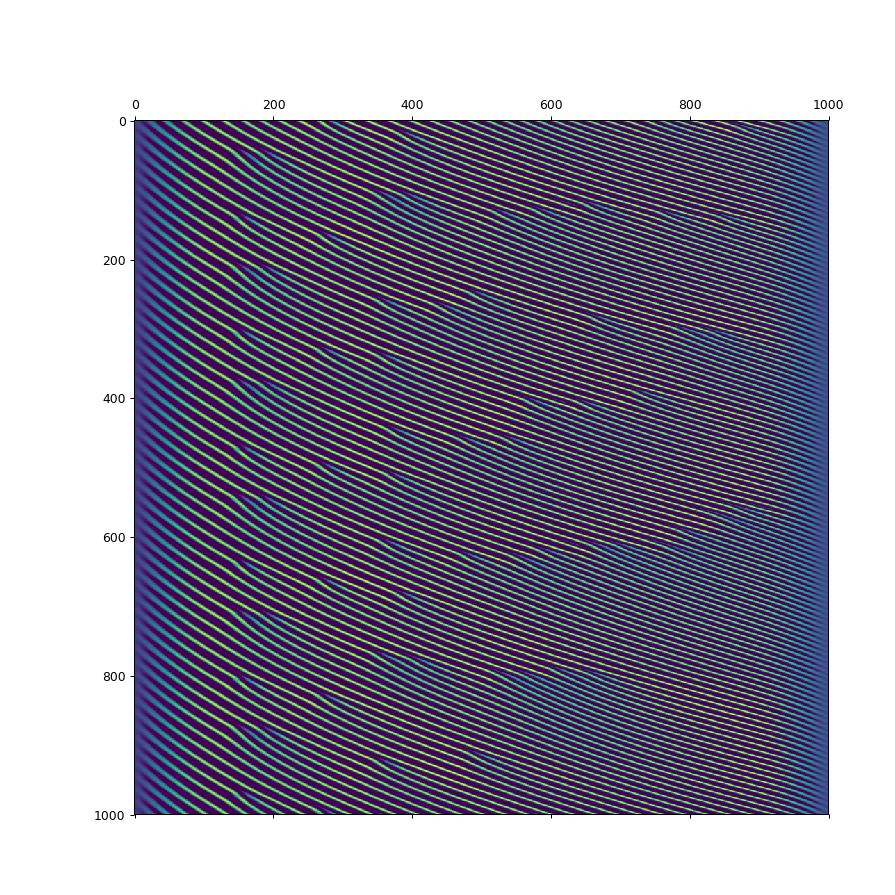

In [197]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.matshow(results[-5000::5])
plt.show()

<IPython.core.display.Javascript object>


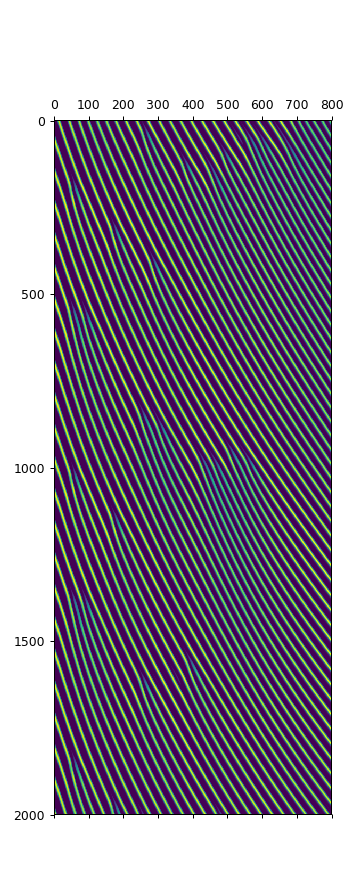

In [201]:
plt.matshow(results[-2000:, 100:900]/np.max(results[-2000:, 100:900], axis=0, keepdims=True))
plt.show()

<IPython.core.display.Javascript object>


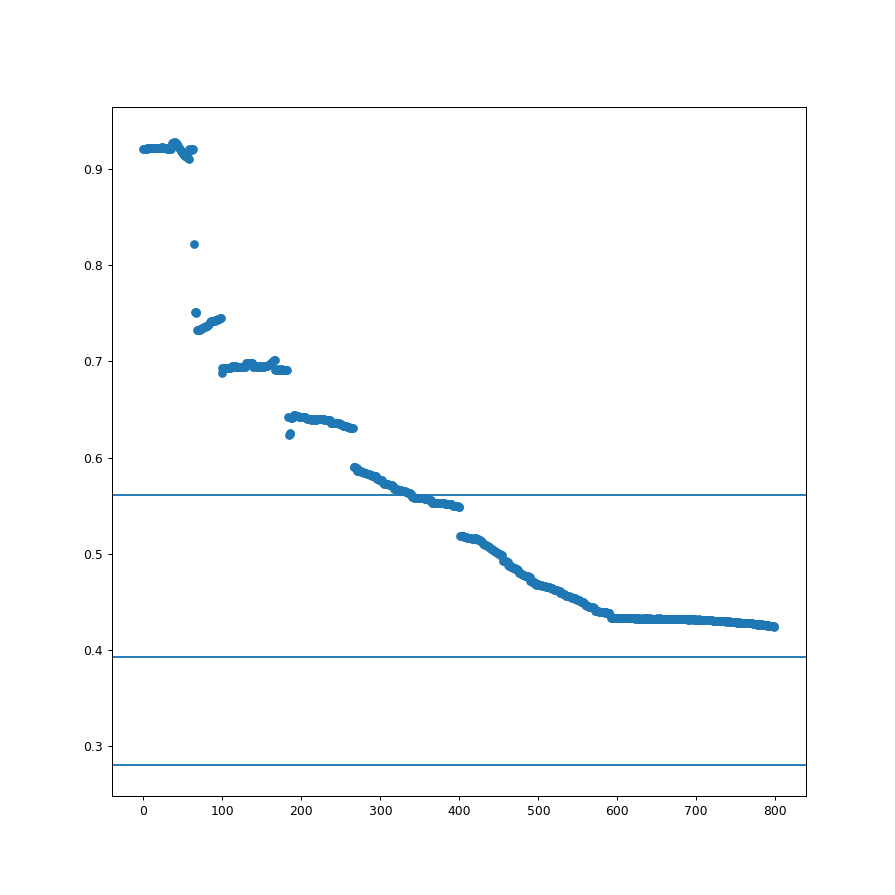

In [203]:
scales = compute_scales(results[-1000:, 100:900]/np.max(results[-1000:, 100:900], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(800), scales*network.dt/sampleFreq)
ax.axhline(.25/0.89146)
ax.axhline(.35/0.89146)
ax.axhline(.5/0.89146)
plt.show()

In [ ]:
network.plotting = True
trueVelocities, estimatedVelocities = network.calculatePathIntegrationError(time=25,
                                                                            dt=0.001,
                                                                            inputNoise=None,
                                                                            )

In [ ]:
g = sns.JointGrid(np.asarray(estimatedVelocities), np.asarray(trueVelocities), ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
plt.title("Path Integration Accuracy")
plt.xlabel("Estimated velocity (cells)")
plt.ylabel("True velocity (m/s)")
plt.tight_layout()
plt.show()

In [ ]:
model = LinearRegression().fit(estimatedVelocities.reshape(-1, 1), trueVelocities)
predictedValues = model.predict(estimatedVelocities.reshape(-1, 1))
meanAbsoluteError = np.mean((np.abs(predictedValues - trueVelocities)))
print("MAE is {}".format(meanAbsoluteError))
percentError = meanAbsoluteError/np.mean(np.abs(trueVelocities))
print("Average error is {}% of average movement speed".format(str(percentError*100)[:4]))